In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import spacy
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import scipy.stats as st
import matplotlib.pyplot as plt

from master_thesis.src import utils

pd.set_option('display.max_columns', 80) # make all columns visible

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ruecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
full = utils.get_raw_df()
#full.set_index('articleId', inplace=True)
#full = full.fillna('')
full.head()

Shape of raw df: (97760, 20)


,publisher,prozentDpa,entrances,timeOnPage,rubric,category,avgTimeOnPagePerWordcount,nr_tokens_text,zeilen,article_text,avgTimeOnPage,prozentVerlag,titel,bounces,date,nr_tokens_publisher,pageviews,pagePath,exits,dpaGuid
articleId,,,,,,,,,,,,,,,,,,,,
SZ_16591,SZ,NaN,1382,48968.0,recht,sz-spezial,0.088949,535,NaN,Coburg Sehr viele Eltern haben eine Vollmacht ...,47.587949,NaN,Sparbuch der Kinder ist tabu : Urteil: Vater d...,76,NaN,535,2411,NaN,1382,NaN
SZ_16595,SZ,NaN,41,2123.0,recht,sz-spezial,0.163308,250,NaN,Berlin Das Verwaltungsgericht Berlin hat entsc...,40.826923,NaN,Gewalt in der Schule : Faustschlag ins Gesicht...,6,NaN,250,92,NaN,40,NaN
SZ_16723,SZ,NaN,308,9972.0,recht,sz-spezial,0.166675,231,NaN,Coburg Nicht jeder Rohrbruch ist versichert: B...,38.501931,NaN,Abflussrohr der Dachrinne defekt: Gebäudeversi...,26,NaN,231,567,NaN,308,NaN
SZ_17146,SZ,NaN,38,6386.0,momente,magazine,0.125154,785,NaN,Alfons Hewener heiratete erst spät. Wadgassen....,98.246154,NaN,„Er war die Liebe meines Lebens“,1,NaN,785,101,NaN,36,NaN
SZ_17184,SZ,NaN,125,9702.0,recht,sz-spezial,0.177933,398,NaN,München Ein Käufer kann erst dann von einem Ka...,70.817518,NaN,Neuer Laptop kaputt - Rücktritt vom Kauf möglich?,9,NaN,398,261,NaN,124,NaN


In [3]:
len(full.index)

97760

In [4]:
len(set(full.index))

97760

In [6]:
full.loc['SZ_17146']

publisher                                                                   SZ
prozentDpa                                                                 NaN
entrances                                                                   38
timeOnPage                                                                6386
rubric                                                                 momente
category                                                              magazine
avgTimeOnPagePerWordcount                                             0.125154
nr_tokens_text                                                             785
zeilen                                                                     NaN
article_text                 Alfons Hewener heiratete erst spät. Wadgassen....
avgTimeOnPage                                                          98.2462
prozentVerlag                                                              NaN
titel                                         „Er wa

In [7]:
#full = full[full.txtExists == True]
#full.shape

In [8]:
full.publisher.value_counts()

NOZ    44004
SZ     32272
TV     21484
Name: publisher, dtype: int64

In [9]:
#full.ausreisser.value_counts()

## Modelling pageviews / avgTimeOnPage with (lemmatized) Bag-of-Words (Ridge Regression)

In [10]:
#full.pageviews.describe().round(3)

In [11]:
#full.avgTimeOnPagePerWordcount.describe().round(3)

In [12]:
full.sort_values(by='avgTimeOnPage', ascending=False)

,publisher,prozentDpa,entrances,timeOnPage,rubric,category,avgTimeOnPagePerWordcount,nr_tokens_text,zeilen,article_text,avgTimeOnPage,prozentVerlag,titel,bounces,date,nr_tokens_publisher,pageviews,pagePath,exits,dpaGuid
articleId,,,,,,,,,,,,,,,,,,,,
NOZ_406939,NOZ,NaN,1407,466409.0,lathen,lokales,2.127468,1768,NaN,„Ich war schon auf dem Weg zur Gaskammer“ Von ...,3761.362903,NaN,NaN,468,NaN,1768,1522,NaN,1398,NaN
NOZ_739925,NOZ,NaN,768,158771.0,medien,deutschland-und-welt,0.866635,2908,NaN,Fiese Fragen an den Moderator: Jörg Thadeusz: ...,2520.174603,NaN,NaN,458,NaN,2908,830,NaN,767,NaN
NOZ_448761,NOZ,NaN,2065,238203.0,osnabrueck,lokales,2.734131,889,NaN,Inhaber von Postfiliale enttäuscht: Zierfische...,2430.642857,NaN,NaN,881,NaN,889,2157,NaN,2059,NaN
NOZ_515048,NOZ,NaN,4331,762153.0,medien,deutschland-und-welt,0.986705,2429,NaN,Gitarrist und Sänger im Interview: Farin Urlau...,2396.707547,NaN,NaN,1953,NaN,2429,4623,NaN,4305,NaN
NOZ_88793,NOZ,NaN,1296,252586.0,medien,deutschland-und-welt,1.018825,2317,NaN,„Das müssen Sie Ihren Hund fragen!“: Hundeprof...,2360.616822,NaN,NaN,685,NaN,2317,1399,NaN,1292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TV_45548009,TV,NaN,14,55.0,fussball,sport,0.002440,322,NaN,Kaiserslautern Das Beste am Derby zwischen Kai...,0.785714,NaN,3. Fußball-Liga : Ekel-Plaka...,1,NaN,322,84,NaN,14,NaN
TV_19380571,TV,NaN,4,382.0,trier-trierer-land,region,0.005595,136,NaN,Trier Bei den Nationalen Spielen von Special ...,0.760956,NaN,Sport : Reporter berichten v...,0,NaN,136,506,NaN,4,NaN
SZ_5847970,SZ,NaN,1,187.0,homburg,saarland,0.001326,438,NaN,St. Ingbert Die Stadt und der Saarpfalz-Kreis ...,0.580745,NaN,Schulen renovieren : Bauarbeiten verbessern da...,0,NaN,438,323,NaN,1,NaN


(0.2536925062999734, 0.0)


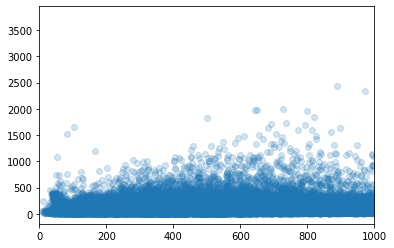

In [13]:
plt.scatter(full.nr_tokens_text, full.avgTimeOnPage, alpha=.2)
plt.xlim(0,1000)

print(st.pearsonr(full.nr_tokens_publisher, full.avgTimeOnPage))

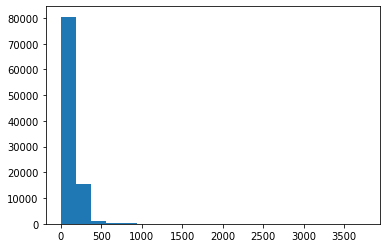

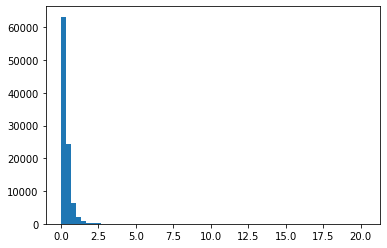

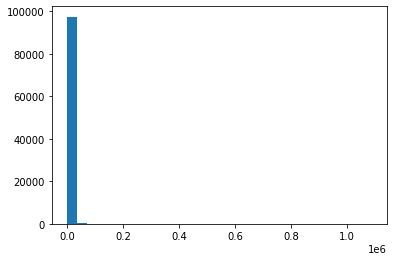

In [14]:
#plt.hist(full.stickiness, 20)
#plt.show()

plt.hist(full.avgTimeOnPage, 20)
plt.show()

plt.hist(full.avgTimeOnPagePerWordcount, 60)
plt.show()

#plt.hist(full.score_pageviews, 50)
#plt.show()

plt.hist(full.pageviews, 30)
plt.show()

In [15]:
df1 = full[full.pageviews <= 20000]
plt.scatter(df1.pageviews, df1.score_pageviews)

AttributeError: 'DataFrame' object has no attribute 'score_pageviews'

In [12]:
#plt.hist(full.score_pageviews, 50)

In [13]:
#for p in full.publisher.unique():
#    print(p)
#    print(full[full.publisher == p].score_pageviews.describe().round(2))

In [15]:
def z_transform(column):
    mean = np.mean(column)
    std = np.std(column)
    z_transformed = [ (value - mean)/std for value in column]
    return z_transformed

In [16]:
from scipy.stats import percentileofscore

def percentile_transform(column):
    percentile_transformed = column.apply(lambda x: percentileofscore(column, x))
    return percentile_transformed

In [23]:
#percentile_transform(full.pageviews)

In [17]:
#full_z = pd.DataFrame()
#
#for p in full.publisher.unique():
#    print(p)
#    tmp = full[full.publisher == p]
#    print(len(tmp))
#    tmp["pageviews_z"] = z_transform(tmp.pageviews)
#    tmp["pageviews_percentile"] = percentile_transform(tmp.pageviews)
#    full_z = pd.concat([full_z, tmp])

In [14]:
# just take articles where ...

df = full[full.txtExists == True]
df = df[df.nr_tokens_publisher >= 70]
#df = df[df.zeilen >= 10]

print(len(df))

3004


(0.0, 1000.0)

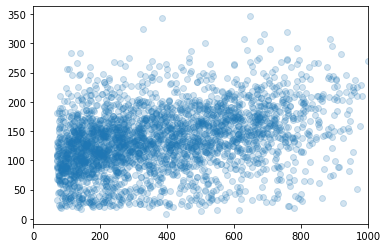

In [15]:
plt.scatter(df.nr_tokens_publisher, df.avgTimeOnPage, alpha=0.2)
plt.xlim(0,1000)

In [16]:
import random
i = random.randint(0,len(df))
print(i)
print(df.iloc[i].pagePath)
print(df.iloc[i].textPublisher_preprocessed)
print(df.iloc[i].nr_tokens_publisher)
print(df.iloc[i].zeilen)


71
https://www.general-anzeiger-bonn.de/freizeit/reise/urlauber-bleiben-bei-einreiseverbot-nicht-auf-kosten-sitzen_aid-49555961
Wenn Länder wegen Corona ihre Grenzen schließen, platzen die Reisepläne vieler deutscher Urlauber. Doch bei einem behördlichen Einreiseverbot bleiben diese in den meisten Fällen zumindest nicht auf ihren Kosten sitzen. Pauschalreisende sind ohnehin gut abgesichert, es gilt das deutsche Pauschalreiserecht. „Wenn ich nicht einreisen kann, bekomme ich vom Veranstalter mein Geld zurück“, erklärt die Reiserechtsexpertin Sabine Fischer-Volk von der Kanzlei Karimi in Berlin. „Ein zusätzlicher Schadenersatz steht mir aber nicht zu, weil es sich um außergewöhnliche Umstände handelt.“ Auch bei individuellen Buchungen von Hotels oder Ferienhäusern gilt nach Einschätzung von Fischer-Volk: „Kann ich das Ziel überhaupt nicht erreichen, bekomme ich das Geld zurück.“ In aller Regel streichen Fluggesellschaften ihre Flüge, sobald ein Land eine Einreisesperre verhängt. „Sobald 

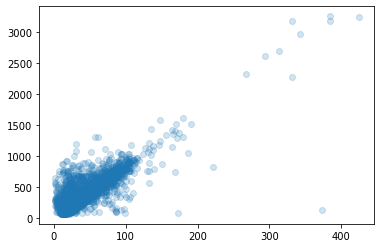

In [17]:
plt.scatter(df.zeilen, df.nr_tokens_publisher, alpha=0.2)

(0.0, 1000.0)

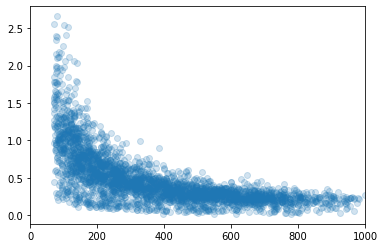

In [18]:
plt.scatter(df.nr_tokens_publisher, df.avgTimeOnPagePerWordcount, alpha=0.2)
plt.xlim(0, 1000)

In [19]:
df[df.zeilen == 10].pagePath

articleId
50621981    https://www.general-anzeiger-bonn.de/ratgeber/...
51177825    https://www.general-anzeiger-bonn.de/news/pano...
51407259    https://www.general-anzeiger-bonn.de/https://w...
49487717    https://www.aachener-zeitung.de/nrw-region/bel...
49687425    https://www.aachener-zeitung.de/lokales/heinsb...
49760547    https://www.aachener-zeitung.de/nrw-region/cor...
50309931    https://www.aachener-zeitung.de/nrw-region/nrw...
52976813    https://www.aachener-zeitung.de/nrw-region/bis...
53051157    https://www.aachener-zeitung.de/nrw-region/mas...
53210589    https://www.aachener-zeitung.de/nrw-region/ank...
49820737    https://www.saarbruecker-zeitung.de/nachrichte...
50263559    https://www.saarbruecker-zeitung.de/nachrichte...
49493709    https://www.volksfreund.de/region/robert-koch-...
Name: pagePath, dtype: object

In [20]:
#plt.scatter(df.pageviews, df.pageviews_percentile)
#len(df[df.pageviews_percentile >= 95])

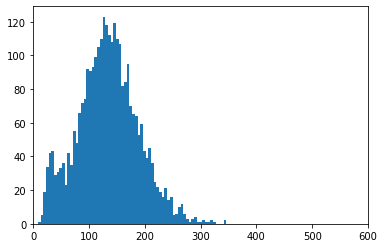

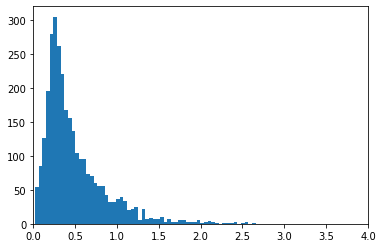

In [21]:
#plt.hist(df.stickiness, 20)
#plt.show()

plt.hist(df.avgTimeOnPage, 70)
plt.xlim(0,600)
plt.show()

plt.hist(df.avgTimeOnPagePerWordcount, 60)
plt.xlim(0,4)
plt.show()

#plt.hist(df.pageviews_percentile, 30)
#plt.show()

#plt.scatter(df.zeilen, df.avgTimeOnPage, alpha = 0.02)
#plt.xlim(0, 100)
#plt.show()
#print(st.pearsonr(df.zeilen, df.avgTimeOnPage))

In [90]:
mit_video = []
ohne_video = []
for ID in full[full.publisher == "NOZ"].index:
    if "video is not" in full.loc[ID, "article_text"]:
        print("mit Video-Text", ID)
        #print(full.loc[ID, "titel"])
        mit_video.append(ID)
        
    else:
        print("ohne", ID)
        ohne_video.append(ID)

ohne NOZ_32
mit Video-Text NOZ_56
mit Video-Text NOZ_186
mit Video-Text NOZ_374
mit Video-Text NOZ_409
mit Video-Text NOZ_823
mit Video-Text NOZ_1210
mit Video-Text NOZ_1248
mit Video-Text NOZ_1326
mit Video-Text NOZ_1332
mit Video-Text NOZ_2250
mit Video-Text NOZ_2630
mit Video-Text NOZ_2750
mit Video-Text NOZ_3407
mit Video-Text NOZ_3408
mit Video-Text NOZ_3411
mit Video-Text NOZ_3412
mit Video-Text NOZ_3416
mit Video-Text NOZ_3420
ohne NOZ_3421
mit Video-Text NOZ_4542
mit Video-Text NOZ_5088
mit Video-Text NOZ_5154
mit Video-Text NOZ_5420
mit Video-Text NOZ_6055
mit Video-Text NOZ_6736
mit Video-Text NOZ_7136
ohne NOZ_7232
mit Video-Text NOZ_7877
mit Video-Text NOZ_8417
mit Video-Text NOZ_8450
mit Video-Text NOZ_8612
mit Video-Text NOZ_9416
mit Video-Text NOZ_11320
mit Video-Text NOZ_11935
mit Video-Text NOZ_12149
ohne NOZ_12675
mit Video-Text NOZ_12850
ohne NOZ_12901
mit Video-Text NOZ_12998
mit Video-Text NOZ_13178
mit Video-Text NOZ_15036
mit Video-Text NOZ_15166
mit Video-Text N

mit Video-Text NOZ_567729
mit Video-Text NOZ_568163
mit Video-Text NOZ_568297
mit Video-Text NOZ_568805
mit Video-Text NOZ_568909
mit Video-Text NOZ_569255
mit Video-Text NOZ_570467
mit Video-Text NOZ_570759
mit Video-Text NOZ_570900
mit Video-Text NOZ_570952
mit Video-Text NOZ_571357
mit Video-Text NOZ_571359
mit Video-Text NOZ_571491
mit Video-Text NOZ_571819
mit Video-Text NOZ_572081
mit Video-Text NOZ_572170
mit Video-Text NOZ_572981
mit Video-Text NOZ_573016
mit Video-Text NOZ_573157
mit Video-Text NOZ_573217
mit Video-Text NOZ_573351
mit Video-Text NOZ_573410
mit Video-Text NOZ_573461
mit Video-Text NOZ_574067
mit Video-Text NOZ_574997
mit Video-Text NOZ_575643
mit Video-Text NOZ_576043
mit Video-Text NOZ_576666
mit Video-Text NOZ_576874
mit Video-Text NOZ_577184
mit Video-Text NOZ_577319
mit Video-Text NOZ_577580
mit Video-Text NOZ_577688
mit Video-Text NOZ_577697
mit Video-Text NOZ_577699
mit Video-Text NOZ_577985
mit Video-Text NOZ_577990
mit Video-Text NOZ_578806
mit Video-Te

mit Video-Text NOZ_855878
mit Video-Text NOZ_856019
mit Video-Text NOZ_857014
mit Video-Text NOZ_857101
mit Video-Text NOZ_858135
mit Video-Text NOZ_858822
mit Video-Text NOZ_858985
mit Video-Text NOZ_859081
mit Video-Text NOZ_859104
mit Video-Text NOZ_859586
mit Video-Text NOZ_859786
mit Video-Text NOZ_859907
mit Video-Text NOZ_860518
mit Video-Text NOZ_860773
mit Video-Text NOZ_860858
mit Video-Text NOZ_860887
mit Video-Text NOZ_860935
mit Video-Text NOZ_860968
mit Video-Text NOZ_861593
mit Video-Text NOZ_862016
mit Video-Text NOZ_862353
mit Video-Text NOZ_862451
mit Video-Text NOZ_862585
mit Video-Text NOZ_862682
mit Video-Text NOZ_862793
mit Video-Text NOZ_863791
mit Video-Text NOZ_864061
mit Video-Text NOZ_864350
mit Video-Text NOZ_864989
mit Video-Text NOZ_865190
mit Video-Text NOZ_865619
mit Video-Text NOZ_866634
mit Video-Text NOZ_866963
mit Video-Text NOZ_867223
mit Video-Text NOZ_867460
mit Video-Text NOZ_867877
mit Video-Text NOZ_867942
mit Video-Text NOZ_868469
mit Video-Te

mit Video-Text NOZ_1521577
mit Video-Text NOZ_1522391
mit Video-Text NOZ_1522938
mit Video-Text NOZ_1523189
mit Video-Text NOZ_1523821
mit Video-Text NOZ_1523987
mit Video-Text NOZ_1526139
mit Video-Text NOZ_1526370
mit Video-Text NOZ_1526498
mit Video-Text NOZ_1527356
mit Video-Text NOZ_1527469
mit Video-Text NOZ_1528084
mit Video-Text NOZ_1528180
mit Video-Text NOZ_1528304
mit Video-Text NOZ_1528521
mit Video-Text NOZ_1529140
mit Video-Text NOZ_1529606
mit Video-Text NOZ_1530291
mit Video-Text NOZ_1530964
mit Video-Text NOZ_1531213
mit Video-Text NOZ_1533311
mit Video-Text NOZ_1533809
mit Video-Text NOZ_1535353
mit Video-Text NOZ_1535441
mit Video-Text NOZ_1536765
mit Video-Text NOZ_1536852
mit Video-Text NOZ_1538390
mit Video-Text NOZ_1539298
mit Video-Text NOZ_1540259
mit Video-Text NOZ_1540842
mit Video-Text NOZ_1540891
mit Video-Text NOZ_1541674
mit Video-Text NOZ_1542323
mit Video-Text NOZ_1542638
mit Video-Text NOZ_1542700
ohne NOZ_1543577
mit Video-Text NOZ_1543777
mit Video-T

mit Video-Text NOZ_1746462
mit Video-Text NOZ_1747087
mit Video-Text NOZ_1747176
mit Video-Text NOZ_1747229
mit Video-Text NOZ_1747232
mit Video-Text NOZ_1747239
ohne NOZ_1747572
mit Video-Text NOZ_1747575
mit Video-Text NOZ_1747602
ohne NOZ_1748427
mit Video-Text NOZ_1749031
mit Video-Text NOZ_1749042
ohne NOZ_1749056
mit Video-Text NOZ_1749801
ohne NOZ_1749974
mit Video-Text NOZ_1750936
mit Video-Text NOZ_1751369
mit Video-Text NOZ_1752089
mit Video-Text NOZ_1752216
mit Video-Text NOZ_1752734
mit Video-Text NOZ_1753280
mit Video-Text NOZ_1754045
mit Video-Text NOZ_1754269
mit Video-Text NOZ_1754315
mit Video-Text NOZ_1755082
mit Video-Text NOZ_1755221
mit Video-Text NOZ_1755280
mit Video-Text NOZ_1755397
mit Video-Text NOZ_1755885
mit Video-Text NOZ_1756939
mit Video-Text NOZ_1757859
mit Video-Text NOZ_1759679
mit Video-Text NOZ_1759786
mit Video-Text NOZ_1760712
mit Video-Text NOZ_1761151
mit Video-Text NOZ_1761361
mit Video-Text NOZ_1761479
mit Video-Text NOZ_1761735
mit Video-Text

mit Video-Text NOZ_1927085
mit Video-Text NOZ_1927092
mit Video-Text NOZ_1927093
mit Video-Text NOZ_1927098
mit Video-Text NOZ_1927100
mit Video-Text NOZ_1927107
mit Video-Text NOZ_1927113
mit Video-Text NOZ_1927119
mit Video-Text NOZ_1927120
mit Video-Text NOZ_1927121
mit Video-Text NOZ_1927128
mit Video-Text NOZ_1927131
mit Video-Text NOZ_1927153
mit Video-Text NOZ_1927155
mit Video-Text NOZ_1927157
mit Video-Text NOZ_1927164
mit Video-Text NOZ_1927168
mit Video-Text NOZ_1927178
mit Video-Text NOZ_1927197
mit Video-Text NOZ_1927203
mit Video-Text NOZ_1927206
mit Video-Text NOZ_1927213
mit Video-Text NOZ_1927216
mit Video-Text NOZ_1927219
mit Video-Text NOZ_1927242
mit Video-Text NOZ_1927244
mit Video-Text NOZ_1927246
mit Video-Text NOZ_1927250
mit Video-Text NOZ_1927267
mit Video-Text NOZ_1927270
mit Video-Text NOZ_1927280
mit Video-Text NOZ_1927294
mit Video-Text NOZ_1927296
mit Video-Text NOZ_1927297
mit Video-Text NOZ_1927299
mit Video-Text NOZ_1927303
mit Video-Text NOZ_1927311
m

mit Video-Text NOZ_1932425
mit Video-Text NOZ_1932426
mit Video-Text NOZ_1932431
ohne NOZ_1932441
ohne NOZ_1932442
mit Video-Text NOZ_1932458
ohne NOZ_1932462
mit Video-Text NOZ_1932475
ohne NOZ_1932477
ohne NOZ_1932481
ohne NOZ_1932484
ohne NOZ_1932486
mit Video-Text NOZ_1932494
ohne NOZ_1932497
mit Video-Text NOZ_1932500
mit Video-Text NOZ_1932506
mit Video-Text NOZ_1932507
ohne NOZ_1932508
ohne NOZ_1932517
ohne NOZ_1932518
mit Video-Text NOZ_1932527
ohne NOZ_1932532
mit Video-Text NOZ_1932536
mit Video-Text NOZ_1932539
mit Video-Text NOZ_1932545
ohne NOZ_1932549
mit Video-Text NOZ_1932552
ohne NOZ_1932562
mit Video-Text NOZ_1932567
ohne NOZ_1932569
ohne NOZ_1932571
ohne NOZ_1932583
ohne NOZ_1932596
ohne NOZ_1932608
ohne NOZ_1932613
ohne NOZ_1932620
ohne NOZ_1932621
ohne NOZ_1932625
mit Video-Text NOZ_1932628
mit Video-Text NOZ_1932630
mit Video-Text NOZ_1932635
ohne NOZ_1932661
ohne NOZ_1932666
mit Video-Text NOZ_1932677
ohne NOZ_1932680
mit Video-Text NOZ_1932681
ohne NOZ_1932743
o

mit Video-Text NOZ_1938238
mit Video-Text NOZ_1938241
mit Video-Text NOZ_1938250
mit Video-Text NOZ_1938253
mit Video-Text NOZ_1938263
mit Video-Text NOZ_1938271
mit Video-Text NOZ_1938274
mit Video-Text NOZ_1938286
mit Video-Text NOZ_1938299
mit Video-Text NOZ_1938322
mit Video-Text NOZ_1938334
mit Video-Text NOZ_1938337
mit Video-Text NOZ_1938346
mit Video-Text NOZ_1938362
mit Video-Text NOZ_1938372
mit Video-Text NOZ_1938377
mit Video-Text NOZ_1938380
mit Video-Text NOZ_1938384
mit Video-Text NOZ_1938387
mit Video-Text NOZ_1938403
mit Video-Text NOZ_1938415
mit Video-Text NOZ_1938418
mit Video-Text NOZ_1938421
mit Video-Text NOZ_1938425
mit Video-Text NOZ_1938427
mit Video-Text NOZ_1938432
mit Video-Text NOZ_1938441
mit Video-Text NOZ_1938444
mit Video-Text NOZ_1938462
mit Video-Text NOZ_1938464
mit Video-Text NOZ_1938480
mit Video-Text NOZ_1938488
mit Video-Text NOZ_1938501
mit Video-Text NOZ_1938509
mit Video-Text NOZ_1938516
mit Video-Text NOZ_1938520
mit Video-Text NOZ_1938524
m

mit Video-Text NOZ_1944538
ohne NOZ_1944549
mit Video-Text NOZ_1944560
ohne NOZ_1944563
mit Video-Text NOZ_1944568
mit Video-Text NOZ_1944574
ohne NOZ_1944584
ohne NOZ_1944592
ohne NOZ_1944603
ohne NOZ_1944609
mit Video-Text NOZ_1944636
mit Video-Text NOZ_1944648
ohne NOZ_1944651
mit Video-Text NOZ_1944680
mit Video-Text NOZ_1944683
ohne NOZ_1944697
ohne NOZ_1944700
ohne NOZ_1944708
mit Video-Text NOZ_1944713
ohne NOZ_1944720
mit Video-Text NOZ_1944733
mit Video-Text NOZ_1944739
mit Video-Text NOZ_1944742
mit Video-Text NOZ_1944744
mit Video-Text NOZ_1944754
mit Video-Text NOZ_1944757
mit Video-Text NOZ_1944764
mit Video-Text NOZ_1944771
ohne NOZ_1944775
mit Video-Text NOZ_1944780
mit Video-Text NOZ_1944782
ohne NOZ_1944784
mit Video-Text NOZ_1944793
mit Video-Text NOZ_1944795
ohne NOZ_1944802
mit Video-Text NOZ_1944804
mit Video-Text NOZ_1944809
mit Video-Text NOZ_1944810
mit Video-Text NOZ_1944820
ohne NOZ_1944825
mit Video-Text NOZ_1944828
ohne NOZ_1944836
ohne NOZ_1944837
ohne NOZ_

mit Video-Text NOZ_1950106
mit Video-Text NOZ_1950108
mit Video-Text NOZ_1950110
mit Video-Text NOZ_1950118
mit Video-Text NOZ_1950124
mit Video-Text NOZ_1950130
mit Video-Text NOZ_1950136
mit Video-Text NOZ_1950138
mit Video-Text NOZ_1950144
mit Video-Text NOZ_1950160
mit Video-Text NOZ_1950162
mit Video-Text NOZ_1950165
mit Video-Text NOZ_1950166
mit Video-Text NOZ_1950169
mit Video-Text NOZ_1950175
mit Video-Text NOZ_1950182
mit Video-Text NOZ_1950183
ohne NOZ_1950186
mit Video-Text NOZ_1950189
mit Video-Text NOZ_1950192
ohne NOZ_1950195
mit Video-Text NOZ_1950202
mit Video-Text NOZ_1950207
mit Video-Text NOZ_1950213
mit Video-Text NOZ_1950218
mit Video-Text NOZ_1950222
mit Video-Text NOZ_1950233
mit Video-Text NOZ_1950235
mit Video-Text NOZ_1950238
mit Video-Text NOZ_1950249
mit Video-Text NOZ_1950254
mit Video-Text NOZ_1950267
mit Video-Text NOZ_1950268
mit Video-Text NOZ_1950281
mit Video-Text NOZ_1950286
mit Video-Text NOZ_1950296
mit Video-Text NOZ_1950316
mit Video-Text NOZ_19

mit Video-Text NOZ_1955040
mit Video-Text NOZ_1955043
mit Video-Text NOZ_1955045
mit Video-Text NOZ_1955050
mit Video-Text NOZ_1955061
mit Video-Text NOZ_1955068
mit Video-Text NOZ_1955070
mit Video-Text NOZ_1955073
mit Video-Text NOZ_1955076
mit Video-Text NOZ_1955081
mit Video-Text NOZ_1955087
mit Video-Text NOZ_1955090
mit Video-Text NOZ_1955094
mit Video-Text NOZ_1955095
mit Video-Text NOZ_1955096
mit Video-Text NOZ_1955097
mit Video-Text NOZ_1955098
mit Video-Text NOZ_1955100
mit Video-Text NOZ_1955102
mit Video-Text NOZ_1955105
mit Video-Text NOZ_1955120
mit Video-Text NOZ_1955122
mit Video-Text NOZ_1955128
mit Video-Text NOZ_1955131
mit Video-Text NOZ_1955139
mit Video-Text NOZ_1955146
mit Video-Text NOZ_1955156
mit Video-Text NOZ_1955158
mit Video-Text NOZ_1955170
mit Video-Text NOZ_1955173
mit Video-Text NOZ_1955174
mit Video-Text NOZ_1955183
mit Video-Text NOZ_1955184
mit Video-Text NOZ_1955187
mit Video-Text NOZ_1955188
mit Video-Text NOZ_1955190
mit Video-Text NOZ_1955193
m

mit Video-Text NOZ_1959221
mit Video-Text NOZ_1959227
mit Video-Text NOZ_1959242
mit Video-Text NOZ_1959259
mit Video-Text NOZ_1959279
mit Video-Text NOZ_1959281
mit Video-Text NOZ_1959284
mit Video-Text NOZ_1959285
mit Video-Text NOZ_1959290
mit Video-Text NOZ_1959294
mit Video-Text NOZ_1959295
mit Video-Text NOZ_1959301
mit Video-Text NOZ_1959305
mit Video-Text NOZ_1959311
mit Video-Text NOZ_1959314
mit Video-Text NOZ_1959325
mit Video-Text NOZ_1959329
mit Video-Text NOZ_1959337
mit Video-Text NOZ_1959343
mit Video-Text NOZ_1959348
mit Video-Text NOZ_1959350
mit Video-Text NOZ_1959354
mit Video-Text NOZ_1959362
mit Video-Text NOZ_1959365
mit Video-Text NOZ_1959368
mit Video-Text NOZ_1959378
mit Video-Text NOZ_1959381
mit Video-Text NOZ_1959387
mit Video-Text NOZ_1959392
mit Video-Text NOZ_1959407
mit Video-Text NOZ_1959409
mit Video-Text NOZ_1959414
mit Video-Text NOZ_1959416
mit Video-Text NOZ_1959419
mit Video-Text NOZ_1959422
mit Video-Text NOZ_1959428
mit Video-Text NOZ_1959433
m

mit Video-Text NOZ_1963199
mit Video-Text NOZ_1963203
mit Video-Text NOZ_1963210
mit Video-Text NOZ_1963213
mit Video-Text NOZ_1963214
mit Video-Text NOZ_1963215
mit Video-Text NOZ_1963221
mit Video-Text NOZ_1963222
mit Video-Text NOZ_1963228
mit Video-Text NOZ_1963230
mit Video-Text NOZ_1963239
mit Video-Text NOZ_1963240
mit Video-Text NOZ_1963246
mit Video-Text NOZ_1963248
mit Video-Text NOZ_1963252
mit Video-Text NOZ_1963255
mit Video-Text NOZ_1963261
mit Video-Text NOZ_1963268
mit Video-Text NOZ_1963275
mit Video-Text NOZ_1963278
mit Video-Text NOZ_1963280
mit Video-Text NOZ_1963283
mit Video-Text NOZ_1963291
mit Video-Text NOZ_1963296
mit Video-Text NOZ_1963301
mit Video-Text NOZ_1963302
mit Video-Text NOZ_1963303
mit Video-Text NOZ_1963305
mit Video-Text NOZ_1963306
mit Video-Text NOZ_1963308
mit Video-Text NOZ_1963311
mit Video-Text NOZ_1963312
mit Video-Text NOZ_1963314
mit Video-Text NOZ_1963317
mit Video-Text NOZ_1963318
mit Video-Text NOZ_1963319
mit Video-Text NOZ_1963321
m

mit Video-Text NOZ_1966476
mit Video-Text NOZ_1966483
mit Video-Text NOZ_1966484
mit Video-Text NOZ_1966486
mit Video-Text NOZ_1966490
mit Video-Text NOZ_1966491
mit Video-Text NOZ_1966500
mit Video-Text NOZ_1966509
mit Video-Text NOZ_1966510
mit Video-Text NOZ_1966511
mit Video-Text NOZ_1966516
mit Video-Text NOZ_1966521
mit Video-Text NOZ_1966525
mit Video-Text NOZ_1966529
mit Video-Text NOZ_1966535
mit Video-Text NOZ_1966538
mit Video-Text NOZ_1966541
mit Video-Text NOZ_1966542
mit Video-Text NOZ_1966547
mit Video-Text NOZ_1966549
mit Video-Text NOZ_1966551
mit Video-Text NOZ_1966552
mit Video-Text NOZ_1966553
mit Video-Text NOZ_1966554
mit Video-Text NOZ_1966556
ohne NOZ_1966559
mit Video-Text NOZ_1966566
mit Video-Text NOZ_1966567
mit Video-Text NOZ_1966569
mit Video-Text NOZ_1966571
mit Video-Text NOZ_1966576
mit Video-Text NOZ_1966579
mit Video-Text NOZ_1966580
mit Video-Text NOZ_1966590
mit Video-Text NOZ_1966598
mit Video-Text NOZ_1966601
mit Video-Text NOZ_1966603
mit Video-T

mit Video-Text NOZ_1969817
mit Video-Text NOZ_1969818
mit Video-Text NOZ_1969820
mit Video-Text NOZ_1969825
mit Video-Text NOZ_1969828
mit Video-Text NOZ_1969829
mit Video-Text NOZ_1969831
mit Video-Text NOZ_1969837
mit Video-Text NOZ_1969853
mit Video-Text NOZ_1969855
mit Video-Text NOZ_1969880
mit Video-Text NOZ_1969887
mit Video-Text NOZ_1969888
mit Video-Text NOZ_1969890
mit Video-Text NOZ_1969893
mit Video-Text NOZ_1969894
mit Video-Text NOZ_1969897
mit Video-Text NOZ_1969898
mit Video-Text NOZ_1969905
mit Video-Text NOZ_1969908
mit Video-Text NOZ_1969914
mit Video-Text NOZ_1969922
ohne NOZ_1969931
mit Video-Text NOZ_1969932
mit Video-Text NOZ_1969933
mit Video-Text NOZ_1969936
ohne NOZ_1969938
mit Video-Text NOZ_1969939
mit Video-Text NOZ_1969940
mit Video-Text NOZ_1969941
mit Video-Text NOZ_1969944
mit Video-Text NOZ_1969945
mit Video-Text NOZ_1969948
mit Video-Text NOZ_1969949
mit Video-Text NOZ_1969956
mit Video-Text NOZ_1969959
mit Video-Text NOZ_1969963
mit Video-Text NOZ_19

ohne NOZ_1974167
mit Video-Text NOZ_1974168
mit Video-Text NOZ_1974169
ohne NOZ_1974175
mit Video-Text NOZ_1974183
ohne NOZ_1974188
ohne NOZ_1974194
mit Video-Text NOZ_1974200
ohne NOZ_1974208
mit Video-Text NOZ_1974210
mit Video-Text NOZ_1974217
mit Video-Text NOZ_1974223
mit Video-Text NOZ_1974225
mit Video-Text NOZ_1974253
mit Video-Text NOZ_1974259
ohne NOZ_1974266
mit Video-Text NOZ_1974285
mit Video-Text NOZ_1974286
mit Video-Text NOZ_1974296
ohne NOZ_1974300
ohne NOZ_1974317
mit Video-Text NOZ_1974320
ohne NOZ_1974322
ohne NOZ_1974323
mit Video-Text NOZ_1974334
mit Video-Text NOZ_1974335
ohne NOZ_1974337
mit Video-Text NOZ_1974345
ohne NOZ_1974354
mit Video-Text NOZ_1974356
ohne NOZ_1974358
mit Video-Text NOZ_1974361
mit Video-Text NOZ_1974368
mit Video-Text NOZ_1974372
mit Video-Text NOZ_1974374
ohne NOZ_1974381
mit Video-Text NOZ_1974384
ohne NOZ_1974390
ohne NOZ_1974392
mit Video-Text NOZ_1974394
mit Video-Text NOZ_1974401
ohne NOZ_1974402
ohne NOZ_1974407
ohne NOZ_1974408
mi

mit Video-Text NOZ_1978901
mit Video-Text NOZ_1978905
mit Video-Text NOZ_1978911
ohne NOZ_1978913
mit Video-Text NOZ_1978923
mit Video-Text NOZ_1978929
mit Video-Text NOZ_1978931
mit Video-Text NOZ_1978933
ohne NOZ_1978934
mit Video-Text NOZ_1978936
mit Video-Text NOZ_1978938
mit Video-Text NOZ_1978941
ohne NOZ_1978952
mit Video-Text NOZ_1978964
mit Video-Text NOZ_1978970
mit Video-Text NOZ_1978972
mit Video-Text NOZ_1978975
ohne NOZ_1978977
mit Video-Text NOZ_1978986
mit Video-Text NOZ_1978988
ohne NOZ_1978993
mit Video-Text NOZ_1978999
mit Video-Text NOZ_1979000
mit Video-Text NOZ_1979001
ohne NOZ_1979008
ohne NOZ_1979017
ohne NOZ_1979020
ohne NOZ_1979029
mit Video-Text NOZ_1979030
mit Video-Text NOZ_1979034
mit Video-Text NOZ_1979036
mit Video-Text NOZ_1979042
ohne NOZ_1979049
mit Video-Text NOZ_1979053
ohne NOZ_1979078
mit Video-Text NOZ_1979080
mit Video-Text NOZ_1979082
mit Video-Text NOZ_1979085
mit Video-Text NOZ_1979092
ohne NOZ_1979094
mit Video-Text NOZ_1979097
ohne NOZ_1979

mit Video-Text NOZ_1983628
mit Video-Text NOZ_1983638
mit Video-Text NOZ_1983651
mit Video-Text NOZ_1983653
mit Video-Text NOZ_1983659
mit Video-Text NOZ_1983661
mit Video-Text NOZ_1983664
mit Video-Text NOZ_1983665
mit Video-Text NOZ_1983668
mit Video-Text NOZ_1983669
mit Video-Text NOZ_1983677
mit Video-Text NOZ_1983685
mit Video-Text NOZ_1983686
mit Video-Text NOZ_1983691
mit Video-Text NOZ_1983696
mit Video-Text NOZ_1983705
mit Video-Text NOZ_1983708
mit Video-Text NOZ_1983710
mit Video-Text NOZ_1983716
mit Video-Text NOZ_1983719
mit Video-Text NOZ_1983721
mit Video-Text NOZ_1983735
mit Video-Text NOZ_1983737
mit Video-Text NOZ_1983741
mit Video-Text NOZ_1983747
mit Video-Text NOZ_1983748
mit Video-Text NOZ_1983751
mit Video-Text NOZ_1983753
mit Video-Text NOZ_1983754
mit Video-Text NOZ_1983756
mit Video-Text NOZ_1983757
mit Video-Text NOZ_1983763
mit Video-Text NOZ_1983785
mit Video-Text NOZ_1983787
mit Video-Text NOZ_1983789
mit Video-Text NOZ_1983792
mit Video-Text NOZ_1983804
m

ohne NOZ_1988279
ohne NOZ_1988281
ohne NOZ_1988284
mit Video-Text NOZ_1988289
ohne NOZ_1988295
mit Video-Text NOZ_1988299
ohne NOZ_1988302
ohne NOZ_1988318
mit Video-Text NOZ_1988331
mit Video-Text NOZ_1988338
ohne NOZ_1988340
ohne NOZ_1988356
ohne NOZ_1988357
ohne NOZ_1988364
mit Video-Text NOZ_1988372
ohne NOZ_1988374
mit Video-Text NOZ_1988375
mit Video-Text NOZ_1988376
mit Video-Text NOZ_1988384
ohne NOZ_1988385
mit Video-Text NOZ_1988393
mit Video-Text NOZ_1988406
ohne NOZ_1988419
ohne NOZ_1988428
ohne NOZ_1988434
ohne NOZ_1988450
mit Video-Text NOZ_1988460
mit Video-Text NOZ_1988465
ohne NOZ_1988477
ohne NOZ_1988489
mit Video-Text NOZ_1988497
ohne NOZ_1988498
ohne NOZ_1988502
ohne NOZ_1988509
ohne NOZ_1988514
ohne NOZ_1988521
ohne NOZ_1988523
mit Video-Text NOZ_1988531
ohne NOZ_1988533
mit Video-Text NOZ_1988536
mit Video-Text NOZ_1988539
ohne NOZ_1988545
ohne NOZ_1988551
mit Video-Text NOZ_1988555
mit Video-Text NOZ_1988562
ohne NOZ_1988586
mit Video-Text NOZ_1988595
ohne NOZ_19

mit Video-Text NOZ_1992745
mit Video-Text NOZ_1992749
mit Video-Text NOZ_1992754
mit Video-Text NOZ_1992759
mit Video-Text NOZ_1992762
mit Video-Text NOZ_1992764
mit Video-Text NOZ_1992770
mit Video-Text NOZ_1992774
mit Video-Text NOZ_1992783
mit Video-Text NOZ_1992784
mit Video-Text NOZ_1992787
mit Video-Text NOZ_1992796
mit Video-Text NOZ_1992820
mit Video-Text NOZ_1992827
mit Video-Text NOZ_1992835
mit Video-Text NOZ_1992855
mit Video-Text NOZ_1992857
mit Video-Text NOZ_1992866
mit Video-Text NOZ_1992867
mit Video-Text NOZ_1992868
mit Video-Text NOZ_1992870
mit Video-Text NOZ_1992878
mit Video-Text NOZ_1992879
mit Video-Text NOZ_1992883
mit Video-Text NOZ_1992885
mit Video-Text NOZ_1992893
mit Video-Text NOZ_1992896
mit Video-Text NOZ_1992898
mit Video-Text NOZ_1992904
mit Video-Text NOZ_1992906
mit Video-Text NOZ_1992907
mit Video-Text NOZ_1992909
mit Video-Text NOZ_1992915
mit Video-Text NOZ_1992919
mit Video-Text NOZ_1992921
mit Video-Text NOZ_1992923
mit Video-Text NOZ_1992924
m

mit Video-Text NOZ_1997357
mit Video-Text NOZ_1997362
mit Video-Text NOZ_1997365
mit Video-Text NOZ_1997366
mit Video-Text NOZ_1997370
mit Video-Text NOZ_1997386
mit Video-Text NOZ_1997393
mit Video-Text NOZ_1997395
mit Video-Text NOZ_1997401
mit Video-Text NOZ_1997403
mit Video-Text NOZ_1997404
mit Video-Text NOZ_1997410
mit Video-Text NOZ_1997412
ohne NOZ_1997415
mit Video-Text NOZ_1997420
mit Video-Text NOZ_1997429
mit Video-Text NOZ_1997430
mit Video-Text NOZ_1997432
mit Video-Text NOZ_1997438
mit Video-Text NOZ_1997441
mit Video-Text NOZ_1997451
mit Video-Text NOZ_1997453
mit Video-Text NOZ_1997455
mit Video-Text NOZ_1997472
mit Video-Text NOZ_1997474
mit Video-Text NOZ_1997481
mit Video-Text NOZ_1997490
mit Video-Text NOZ_1997498
mit Video-Text NOZ_1997503
mit Video-Text NOZ_1997517
mit Video-Text NOZ_1997526
mit Video-Text NOZ_1997529
mit Video-Text NOZ_1997531
mit Video-Text NOZ_1997559
mit Video-Text NOZ_1997560
mit Video-Text NOZ_1997567
mit Video-Text NOZ_1997580
mit Video-T

mit Video-Text NOZ_2002103
mit Video-Text NOZ_2002107
mit Video-Text NOZ_2002109
mit Video-Text NOZ_2002114
mit Video-Text NOZ_2002120
mit Video-Text NOZ_2002122
mit Video-Text NOZ_2002126
mit Video-Text NOZ_2002128
mit Video-Text NOZ_2002132
mit Video-Text NOZ_2002136
mit Video-Text NOZ_2002138
mit Video-Text NOZ_2002142
mit Video-Text NOZ_2002150
mit Video-Text NOZ_2002151
mit Video-Text NOZ_2002154
mit Video-Text NOZ_2002158
mit Video-Text NOZ_2002160
mit Video-Text NOZ_2002161
mit Video-Text NOZ_2002163
mit Video-Text NOZ_2002168
mit Video-Text NOZ_2002174
mit Video-Text NOZ_2002179
mit Video-Text NOZ_2002186
mit Video-Text NOZ_2002199
mit Video-Text NOZ_2002205
mit Video-Text NOZ_2002213
mit Video-Text NOZ_2002215
mit Video-Text NOZ_2002217
mit Video-Text NOZ_2002218
mit Video-Text NOZ_2002221
mit Video-Text NOZ_2002228
ohne NOZ_2002231
mit Video-Text NOZ_2002232
mit Video-Text NOZ_2002241
mit Video-Text NOZ_2002243
mit Video-Text NOZ_2002245
mit Video-Text NOZ_2002249
mit Video-T

mit Video-Text NOZ_2006471
mit Video-Text NOZ_2006473
mit Video-Text NOZ_2006475
mit Video-Text NOZ_2006477
mit Video-Text NOZ_2006480
mit Video-Text NOZ_2006483
mit Video-Text NOZ_2006486
mit Video-Text NOZ_2006494
mit Video-Text NOZ_2006499
mit Video-Text NOZ_2006500
mit Video-Text NOZ_2006516
mit Video-Text NOZ_2006523
mit Video-Text NOZ_2006534
mit Video-Text NOZ_2006545
mit Video-Text NOZ_2006547
mit Video-Text NOZ_2006549
mit Video-Text NOZ_2006551
mit Video-Text NOZ_2006553
mit Video-Text NOZ_2006557
mit Video-Text NOZ_2006566
ohne NOZ_2006569
mit Video-Text NOZ_2006582
mit Video-Text NOZ_2006585
mit Video-Text NOZ_2006590
mit Video-Text NOZ_2006604
mit Video-Text NOZ_2006606
mit Video-Text NOZ_2006612
ohne NOZ_2006617
ohne NOZ_2006619
mit Video-Text NOZ_2006621
mit Video-Text NOZ_2006633
mit Video-Text NOZ_2006642
mit Video-Text NOZ_2006644
mit Video-Text NOZ_2006647
mit Video-Text NOZ_2006652
mit Video-Text NOZ_2006661
mit Video-Text NOZ_2006665
mit Video-Text NOZ_2006668
mit 

ohne NOZ_2011055
ohne NOZ_2011063
ohne NOZ_2011065
ohne NOZ_2011068
ohne NOZ_2011084
ohne NOZ_2011092
ohne NOZ_2011095
mit Video-Text NOZ_2011097
mit Video-Text NOZ_2011112
ohne NOZ_2011118
mit Video-Text NOZ_2011137
ohne NOZ_2011140
mit Video-Text NOZ_2011142
ohne NOZ_2011150
ohne NOZ_2011158
ohne NOZ_2011165
ohne NOZ_2011169
ohne NOZ_2011177
ohne NOZ_2011186
ohne NOZ_2011190
ohne NOZ_2011199
ohne NOZ_2011205
ohne NOZ_2011217
ohne NOZ_2011219
ohne NOZ_2011230
ohne NOZ_2011232
ohne NOZ_2011239
ohne NOZ_2011241
ohne NOZ_2011256
ohne NOZ_2011258
ohne NOZ_2011259
ohne NOZ_2011260
ohne NOZ_2011262
ohne NOZ_2011266
ohne NOZ_2011276
ohne NOZ_2011279
ohne NOZ_2011282
ohne NOZ_2011294
ohne NOZ_2011295
ohne NOZ_2011296
ohne NOZ_2011304
ohne NOZ_2011309
ohne NOZ_2011315
ohne NOZ_2011318
ohne NOZ_2011328
mit Video-Text NOZ_2011338
ohne NOZ_2011339
ohne NOZ_2011340
ohne NOZ_2011349
ohne NOZ_2011355
ohne NOZ_2011358
mit Video-Text NOZ_2011365
ohne NOZ_2011373
ohne NOZ_2011382
ohne NOZ_2011390
ohne 

mit Video-Text NOZ_2015931
mit Video-Text NOZ_2015933
mit Video-Text NOZ_2015939
mit Video-Text NOZ_2015943
mit Video-Text NOZ_2015944
mit Video-Text NOZ_2015948
mit Video-Text NOZ_2015952
mit Video-Text NOZ_2015957
mit Video-Text NOZ_2015959
mit Video-Text NOZ_2015963
mit Video-Text NOZ_2015967
mit Video-Text NOZ_2015977
mit Video-Text NOZ_2015983
mit Video-Text NOZ_2015986
mit Video-Text NOZ_2015989
mit Video-Text NOZ_2015991
mit Video-Text NOZ_2015996
mit Video-Text NOZ_2016004
mit Video-Text NOZ_2016006
mit Video-Text NOZ_2016010
mit Video-Text NOZ_2016013
ohne NOZ_2016017
mit Video-Text NOZ_2016019
mit Video-Text NOZ_2016022
mit Video-Text NOZ_2016024
mit Video-Text NOZ_2016026
mit Video-Text NOZ_2016028
mit Video-Text NOZ_2016034
mit Video-Text NOZ_2016035
mit Video-Text NOZ_2016042
mit Video-Text NOZ_2016045
mit Video-Text NOZ_2016051
mit Video-Text NOZ_2016053
mit Video-Text NOZ_2016060
ohne NOZ_2016065
mit Video-Text NOZ_2016071
mit Video-Text NOZ_2016078
mit Video-Text NOZ_20

mit Video-Text NOZ_2019880
mit Video-Text NOZ_2019882
mit Video-Text NOZ_2019884
mit Video-Text NOZ_2019885
mit Video-Text NOZ_2019886
mit Video-Text NOZ_2019892
mit Video-Text NOZ_2019903
mit Video-Text NOZ_2019910
mit Video-Text NOZ_2019912
mit Video-Text NOZ_2019913
mit Video-Text NOZ_2019915
mit Video-Text NOZ_2019927
mit Video-Text NOZ_2019936
mit Video-Text NOZ_2019940
mit Video-Text NOZ_2019942
mit Video-Text NOZ_2019948
mit Video-Text NOZ_2019951
mit Video-Text NOZ_2019953
mit Video-Text NOZ_2019959
mit Video-Text NOZ_2019961
mit Video-Text NOZ_2019967
mit Video-Text NOZ_2019972
mit Video-Text NOZ_2019974
mit Video-Text NOZ_2019988
mit Video-Text NOZ_2019990
mit Video-Text NOZ_2019996
mit Video-Text NOZ_2019998
mit Video-Text NOZ_2020000
mit Video-Text NOZ_2020010
mit Video-Text NOZ_2020012
mit Video-Text NOZ_2020013
mit Video-Text NOZ_2020020
ohne NOZ_2020030
mit Video-Text NOZ_2020053
mit Video-Text NOZ_2020054
mit Video-Text NOZ_2020068
mit Video-Text NOZ_2020069
mit Video-T

mit Video-Text NOZ_2023645
mit Video-Text NOZ_2023648
mit Video-Text NOZ_2023658
mit Video-Text NOZ_2023659
ohne NOZ_2023663
ohne NOZ_2023669
mit Video-Text NOZ_2023672
mit Video-Text NOZ_2023677
mit Video-Text NOZ_2023683
mit Video-Text NOZ_2023686
mit Video-Text NOZ_2023691
mit Video-Text NOZ_2023695
mit Video-Text NOZ_2023697
mit Video-Text NOZ_2023699
mit Video-Text NOZ_2023704
mit Video-Text NOZ_2023706
mit Video-Text NOZ_2023713
mit Video-Text NOZ_2023717
mit Video-Text NOZ_2023721
mit Video-Text NOZ_2023725
mit Video-Text NOZ_2023729
mit Video-Text NOZ_2023742
mit Video-Text NOZ_2023743
mit Video-Text NOZ_2023751
mit Video-Text NOZ_2023752
mit Video-Text NOZ_2023755
mit Video-Text NOZ_2023756
mit Video-Text NOZ_2023758
mit Video-Text NOZ_2023765
mit Video-Text NOZ_2023767
mit Video-Text NOZ_2023769
mit Video-Text NOZ_2023771
mit Video-Text NOZ_2023795
mit Video-Text NOZ_2023797
mit Video-Text NOZ_2023805
mit Video-Text NOZ_2023816
mit Video-Text NOZ_2023825
mit Video-Text NOZ_20

mit Video-Text NOZ_2027753
mit Video-Text NOZ_2027763
mit Video-Text NOZ_2027765
mit Video-Text NOZ_2027767
mit Video-Text NOZ_2027771
mit Video-Text NOZ_2027772
mit Video-Text NOZ_2027774
mit Video-Text NOZ_2027778
mit Video-Text NOZ_2027779
mit Video-Text NOZ_2027782
mit Video-Text NOZ_2027784
mit Video-Text NOZ_2027793
mit Video-Text NOZ_2027795
mit Video-Text NOZ_2027799
mit Video-Text NOZ_2027800
mit Video-Text NOZ_2027803
mit Video-Text NOZ_2027805
mit Video-Text NOZ_2027811
mit Video-Text NOZ_2027813
mit Video-Text NOZ_2027815
mit Video-Text NOZ_2027822
mit Video-Text NOZ_2027823
mit Video-Text NOZ_2027829
mit Video-Text NOZ_2027842
mit Video-Text NOZ_2027845
mit Video-Text NOZ_2027850
mit Video-Text NOZ_2027855
mit Video-Text NOZ_2027858
mit Video-Text NOZ_2027866
mit Video-Text NOZ_2027869
mit Video-Text NOZ_2027874
mit Video-Text NOZ_2027878
ohne NOZ_2027880
mit Video-Text NOZ_2027886
mit Video-Text NOZ_2027892
mit Video-Text NOZ_2027900
mit Video-Text NOZ_2027912
mit Video-T

mit Video-Text NOZ_2031918
mit Video-Text NOZ_2031931
mit Video-Text NOZ_2031933
mit Video-Text NOZ_2031947
mit Video-Text NOZ_2031951
mit Video-Text NOZ_2031961
mit Video-Text NOZ_2031964
mit Video-Text NOZ_2031969
ohne NOZ_2031973
mit Video-Text NOZ_2031975
mit Video-Text NOZ_2031978
mit Video-Text NOZ_2031980
mit Video-Text NOZ_2031988
mit Video-Text NOZ_2031995
mit Video-Text NOZ_2032004
mit Video-Text NOZ_2032013
mit Video-Text NOZ_2032019
mit Video-Text NOZ_2032026
mit Video-Text NOZ_2032028
mit Video-Text NOZ_2032029
mit Video-Text NOZ_2032034
mit Video-Text NOZ_2032040
mit Video-Text NOZ_2032042
mit Video-Text NOZ_2032058
mit Video-Text NOZ_2032060
mit Video-Text NOZ_2032061
mit Video-Text NOZ_2032062
mit Video-Text NOZ_2032069
mit Video-Text NOZ_2032075
mit Video-Text NOZ_2032077
mit Video-Text NOZ_2032079
mit Video-Text NOZ_2032081
mit Video-Text NOZ_2032085
mit Video-Text NOZ_2032086
mit Video-Text NOZ_2032088
mit Video-Text NOZ_2032090
mit Video-Text NOZ_2032091
mit Video-T

mit Video-Text NOZ_2035803
mit Video-Text NOZ_2035819
mit Video-Text NOZ_2035825
mit Video-Text NOZ_2035827
mit Video-Text NOZ_2035842
mit Video-Text NOZ_2035846
mit Video-Text NOZ_2035850
mit Video-Text NOZ_2035861
mit Video-Text NOZ_2035868
mit Video-Text NOZ_2035869
mit Video-Text NOZ_2035873
mit Video-Text NOZ_2035877
mit Video-Text NOZ_2035885
mit Video-Text NOZ_2035887
mit Video-Text NOZ_2035907
mit Video-Text NOZ_2035910
mit Video-Text NOZ_2035930
mit Video-Text NOZ_2035931
ohne NOZ_2035940
mit Video-Text NOZ_2035946
mit Video-Text NOZ_2035948
mit Video-Text NOZ_2035952
mit Video-Text NOZ_2035960
mit Video-Text NOZ_2035963
mit Video-Text NOZ_2035965
mit Video-Text NOZ_2035966
mit Video-Text NOZ_2035970
mit Video-Text NOZ_2035984
mit Video-Text NOZ_2035994
mit Video-Text NOZ_2035996
mit Video-Text NOZ_2035998
ohne NOZ_2036000
mit Video-Text NOZ_2036011
mit Video-Text NOZ_2036013
mit Video-Text NOZ_2036021
mit Video-Text NOZ_2036026
ohne NOZ_2036029
mit Video-Text NOZ_2036035
mit 

mit Video-Text NOZ_2039858
mit Video-Text NOZ_2039869
mit Video-Text NOZ_2039873
mit Video-Text NOZ_2039881
mit Video-Text NOZ_2039883
ohne NOZ_2039887
mit Video-Text NOZ_2039890
mit Video-Text NOZ_2039894
mit Video-Text NOZ_2039896
mit Video-Text NOZ_2039902
mit Video-Text NOZ_2039905
ohne NOZ_2039907
mit Video-Text NOZ_2039910
mit Video-Text NOZ_2039917
mit Video-Text NOZ_2039919
mit Video-Text NOZ_2039926
mit Video-Text NOZ_2039930
mit Video-Text NOZ_2039933
mit Video-Text NOZ_2039935
mit Video-Text NOZ_2039941
mit Video-Text NOZ_2039944
mit Video-Text NOZ_2039947
mit Video-Text NOZ_2039949
mit Video-Text NOZ_2039962
mit Video-Text NOZ_2039964
mit Video-Text NOZ_2039971
mit Video-Text NOZ_2039977
mit Video-Text NOZ_2039981
mit Video-Text NOZ_2039985
mit Video-Text NOZ_2039986
mit Video-Text NOZ_2039994
mit Video-Text NOZ_2039997
mit Video-Text NOZ_2040008
mit Video-Text NOZ_2040014
mit Video-Text NOZ_2040020
mit Video-Text NOZ_2040021
mit Video-Text NOZ_2040028
mit Video-Text NOZ_20

mit Video-Text NOZ_2043782
mit Video-Text NOZ_2043784
mit Video-Text NOZ_2043786
mit Video-Text NOZ_2043791
mit Video-Text NOZ_2043793
ohne NOZ_2043794
mit Video-Text NOZ_2043797
mit Video-Text NOZ_2043802
mit Video-Text NOZ_2043806
mit Video-Text NOZ_2043807
mit Video-Text NOZ_2043809
mit Video-Text NOZ_2043812
ohne NOZ_2043819
mit Video-Text NOZ_2043822
mit Video-Text NOZ_2043823
mit Video-Text NOZ_2043825
mit Video-Text NOZ_2043833
mit Video-Text NOZ_2043841
mit Video-Text NOZ_2043848
mit Video-Text NOZ_2043856
mit Video-Text NOZ_2043861
mit Video-Text NOZ_2043864
mit Video-Text NOZ_2043870
mit Video-Text NOZ_2043878
mit Video-Text NOZ_2043884
mit Video-Text NOZ_2043890
mit Video-Text NOZ_2043892
mit Video-Text NOZ_2043900
mit Video-Text NOZ_2043901
mit Video-Text NOZ_2043905
mit Video-Text NOZ_2043907
mit Video-Text NOZ_2043912
mit Video-Text NOZ_2043919
mit Video-Text NOZ_2043923
mit Video-Text NOZ_2043927
mit Video-Text NOZ_2043929
mit Video-Text NOZ_2043932
mit Video-Text NOZ_20

ohne NOZ_2047966
ohne NOZ_2047967
ohne NOZ_2047968
ohne NOZ_2047969
ohne NOZ_2047972
ohne NOZ_2047974
ohne NOZ_2047980
ohne NOZ_2047981
ohne NOZ_2047991
ohne NOZ_2047994
ohne NOZ_2048004
mit Video-Text NOZ_2048007
ohne NOZ_2048022
ohne NOZ_2048023
ohne NOZ_2048031
ohne NOZ_2048036
ohne NOZ_2048038
ohne NOZ_2048040
ohne NOZ_2048050
mit Video-Text NOZ_2048059
ohne NOZ_2048066
ohne NOZ_2048069
ohne NOZ_2048084
mit Video-Text NOZ_2048097
mit Video-Text NOZ_2048099
mit Video-Text NOZ_2048105
mit Video-Text NOZ_2048111
mit Video-Text NOZ_2048119
mit Video-Text NOZ_2048121
mit Video-Text NOZ_2048128
mit Video-Text NOZ_2048134
mit Video-Text NOZ_2048148
mit Video-Text NOZ_2048151
ohne NOZ_2048153
mit Video-Text NOZ_2048157
mit Video-Text NOZ_2048166
mit Video-Text NOZ_2048168
mit Video-Text NOZ_2048170
mit Video-Text NOZ_2048173
ohne NOZ_2048174
mit Video-Text NOZ_2048181
mit Video-Text NOZ_2048182
mit Video-Text NOZ_2048186
mit Video-Text NOZ_2048191
mit Video-Text NOZ_2048193
mit Video-Text 

mit Video-Text NOZ_2052104
mit Video-Text NOZ_2052116
mit Video-Text NOZ_2052124
mit Video-Text NOZ_2052127
ohne NOZ_2052128
mit Video-Text NOZ_2052133
mit Video-Text NOZ_2052138
mit Video-Text NOZ_2052139
mit Video-Text NOZ_2052141
mit Video-Text NOZ_2052145
mit Video-Text NOZ_2052147
ohne NOZ_2052148
mit Video-Text NOZ_2052157
mit Video-Text NOZ_2052165
mit Video-Text NOZ_2052167
mit Video-Text NOZ_2052169
mit Video-Text NOZ_2052172
ohne NOZ_2052174
mit Video-Text NOZ_2052181
ohne NOZ_2052183
mit Video-Text NOZ_2052188
ohne NOZ_2052194
ohne NOZ_2052197
mit Video-Text NOZ_2052199
mit Video-Text NOZ_2052205
mit Video-Text NOZ_2052207
mit Video-Text NOZ_2052213
ohne NOZ_2052221
mit Video-Text NOZ_2052223
ohne NOZ_2052228
mit Video-Text NOZ_2052239
ohne NOZ_2052241
ohne NOZ_2052249
ohne NOZ_2052257
ohne NOZ_2052261
mit Video-Text NOZ_2052267
mit Video-Text NOZ_2052268
mit Video-Text NOZ_2052271
mit Video-Text NOZ_2052277
mit Video-Text NOZ_2052279
ohne NOZ_2052294
mit Video-Text NOZ_2052

mit Video-Text NOZ_2056013
mit Video-Text NOZ_2056021
mit Video-Text NOZ_2056032
mit Video-Text NOZ_2056035
mit Video-Text NOZ_2056036
mit Video-Text NOZ_2056046
mit Video-Text NOZ_2056048
mit Video-Text NOZ_2056088
mit Video-Text NOZ_2056103
ohne NOZ_2056122
mit Video-Text NOZ_2056124
mit Video-Text NOZ_2056131
ohne NOZ_2056134
mit Video-Text NOZ_2056152
mit Video-Text NOZ_2056154
mit Video-Text NOZ_2056160
mit Video-Text NOZ_2056164
mit Video-Text NOZ_2056190
mit Video-Text NOZ_2056192
mit Video-Text NOZ_2056200
mit Video-Text NOZ_2056211
mit Video-Text NOZ_2056218
mit Video-Text NOZ_2056219
mit Video-Text NOZ_2056222
mit Video-Text NOZ_2056225
ohne NOZ_2056227
ohne NOZ_2056228
mit Video-Text NOZ_2056230
mit Video-Text NOZ_2056236
mit Video-Text NOZ_2056239
ohne NOZ_2056242
mit Video-Text NOZ_2056248
mit Video-Text NOZ_2056250
mit Video-Text NOZ_2056258
mit Video-Text NOZ_2056265
ohne NOZ_2056267
ohne NOZ_2056271
mit Video-Text NOZ_2056282
ohne NOZ_2056285
mit Video-Text NOZ_2056289


ohne NOZ_2060027
ohne NOZ_2060035
ohne NOZ_2060040
ohne NOZ_2060046
ohne NOZ_2060059
ohne NOZ_2060064
ohne NOZ_2060067
ohne NOZ_2060071
ohne NOZ_2060074
ohne NOZ_2060079
ohne NOZ_2060082
ohne NOZ_2060090
ohne NOZ_2060095
ohne NOZ_2060097
ohne NOZ_2060099
ohne NOZ_2060102
ohne NOZ_2060103
mit Video-Text NOZ_2060107
ohne NOZ_2060110
ohne NOZ_2060115
mit Video-Text NOZ_2060117
mit Video-Text NOZ_2060122
ohne NOZ_2060127
ohne NOZ_2060136
mit Video-Text NOZ_2060143
mit Video-Text NOZ_2060145
mit Video-Text NOZ_2060151
ohne NOZ_2060154
mit Video-Text NOZ_2060157
ohne NOZ_2060159
ohne NOZ_2060160
ohne NOZ_2060162
mit Video-Text NOZ_2060168
mit Video-Text NOZ_2060172
mit Video-Text NOZ_2060178
ohne NOZ_2060182
mit Video-Text NOZ_2060190
mit Video-Text NOZ_2060192
ohne NOZ_2060198
mit Video-Text NOZ_2060206
mit Video-Text NOZ_2060207
mit Video-Text NOZ_2060213
ohne NOZ_2060218
mit Video-Text NOZ_2060220
mit Video-Text NOZ_2060239
ohne NOZ_2060251
ohne NOZ_2060258
ohne NOZ_2060265
ohne NOZ_20602

ohne NOZ_2064119
mit Video-Text NOZ_2064122
ohne NOZ_2064123
ohne NOZ_2064126
ohne NOZ_2064133
ohne NOZ_2064135
ohne NOZ_2064136
ohne NOZ_2064138
ohne NOZ_2064152
ohne NOZ_2064154
ohne NOZ_2064155
mit Video-Text NOZ_2064157
ohne NOZ_2064164
ohne NOZ_2064170
ohne NOZ_2064172
ohne NOZ_2064175
ohne NOZ_2064183
ohne NOZ_2064185
mit Video-Text NOZ_2064187
mit Video-Text NOZ_2064189
ohne NOZ_2064191
ohne NOZ_2064194
mit Video-Text NOZ_2064196
ohne NOZ_2064198
ohne NOZ_2064207
ohne NOZ_2064209
ohne NOZ_2064215
mit Video-Text NOZ_2064224
ohne NOZ_2064226
mit Video-Text NOZ_2064228
ohne NOZ_2064229
mit Video-Text NOZ_2064231
mit Video-Text NOZ_2064239
ohne NOZ_2064244
mit Video-Text NOZ_2064247
ohne NOZ_2064261
mit Video-Text NOZ_2064262
mit Video-Text NOZ_2064269
mit Video-Text NOZ_2064271
mit Video-Text NOZ_2064274
mit Video-Text NOZ_2064275
mit Video-Text NOZ_2064282
mit Video-Text NOZ_2064283
ohne NOZ_2064285
mit Video-Text NOZ_2064291
mit Video-Text NOZ_2064292
mit Video-Text NOZ_2064301
m

mit Video-Text NOZ_2067973
mit Video-Text NOZ_2067980
ohne NOZ_2067985
mit Video-Text NOZ_2067990
mit Video-Text NOZ_2067992
ohne NOZ_2067994
mit Video-Text NOZ_2067998
mit Video-Text NOZ_2068002
ohne NOZ_2068008
mit Video-Text NOZ_2068014
mit Video-Text NOZ_2068030
mit Video-Text NOZ_2068032
mit Video-Text NOZ_2068034
mit Video-Text NOZ_2068035
mit Video-Text NOZ_2068040
mit Video-Text NOZ_2068042
mit Video-Text NOZ_2068044
mit Video-Text NOZ_2068055
mit Video-Text NOZ_2068058
mit Video-Text NOZ_2068060
mit Video-Text NOZ_2068062
mit Video-Text NOZ_2068065
ohne NOZ_2068067
ohne NOZ_2068074
mit Video-Text NOZ_2068081
ohne NOZ_2068084
ohne NOZ_2068085
ohne NOZ_2068088
ohne NOZ_2068096
mit Video-Text NOZ_2068105
ohne NOZ_2068106
mit Video-Text NOZ_2068111
ohne NOZ_2068113
mit Video-Text NOZ_2068121
ohne NOZ_2068123
ohne NOZ_2068125
ohne NOZ_2068131
mit Video-Text NOZ_2068139
ohne NOZ_2068141
mit Video-Text NOZ_2068163
mit Video-Text NOZ_2068166
ohne NOZ_2068180
mit Video-Text NOZ_2068182

mit Video-Text NOZ_2072482
mit Video-Text NOZ_2072484
mit Video-Text NOZ_2072494
mit Video-Text NOZ_2072497
mit Video-Text NOZ_2072501
ohne NOZ_2072503
mit Video-Text NOZ_2072509
mit Video-Text NOZ_2072510
mit Video-Text NOZ_2072512
ohne NOZ_2072518
ohne NOZ_2072521
mit Video-Text NOZ_2072522
ohne NOZ_2072524
mit Video-Text NOZ_2072525
mit Video-Text NOZ_2072531
mit Video-Text NOZ_2072532
mit Video-Text NOZ_2072536
ohne NOZ_2072538
mit Video-Text NOZ_2072540
mit Video-Text NOZ_2072545
mit Video-Text NOZ_2072553
mit Video-Text NOZ_2072555
mit Video-Text NOZ_2072556
ohne NOZ_2072562
mit Video-Text NOZ_2072564
mit Video-Text NOZ_2072567
mit Video-Text NOZ_2072569
ohne NOZ_2072575
mit Video-Text NOZ_2072578
mit Video-Text NOZ_2072582
mit Video-Text NOZ_2072587
ohne NOZ_2072588
mit Video-Text NOZ_2072590
mit Video-Text NOZ_2072592
mit Video-Text NOZ_2072594
mit Video-Text NOZ_2072600
mit Video-Text NOZ_2072602
ohne NOZ_2072612
ohne NOZ_2072622
ohne NOZ_2072629
ohne NOZ_2072639
ohne NOZ_2072

ohne NOZ_2076523
ohne NOZ_2076529
ohne NOZ_2076534
ohne NOZ_2076536
ohne NOZ_2076540
mit Video-Text NOZ_2076551
ohne NOZ_2076554
ohne NOZ_2076561
mit Video-Text NOZ_2076562
ohne NOZ_2076564
mit Video-Text NOZ_2076586
ohne NOZ_2076593
ohne NOZ_2076595
ohne NOZ_2076604
ohne NOZ_2076608
ohne NOZ_2076615
ohne NOZ_2076625
ohne NOZ_2076628
ohne NOZ_2076629
ohne NOZ_2076631
ohne NOZ_2076633
ohne NOZ_2076640
ohne NOZ_2076642
ohne NOZ_2076647
ohne NOZ_2076649
ohne NOZ_2076651
ohne NOZ_2076652
ohne NOZ_2076654
ohne NOZ_2076656
ohne NOZ_2076658
ohne NOZ_2076668
ohne NOZ_2076674
ohne NOZ_2076676
ohne NOZ_2076677
ohne NOZ_2076679
ohne NOZ_2076682
ohne NOZ_2076684
ohne NOZ_2076687
mit Video-Text NOZ_2076690
mit Video-Text NOZ_2076696
ohne NOZ_2076698
ohne NOZ_2076701
ohne NOZ_2076702
ohne NOZ_2076706
ohne NOZ_2076716
ohne NOZ_2076723
ohne NOZ_2076725
ohne NOZ_2076726
ohne NOZ_2076727
ohne NOZ_2076731
ohne NOZ_2076739
ohne NOZ_2076741
ohne NOZ_2076743
ohne NOZ_2076745
ohne NOZ_2076757
ohne NOZ_207675

ohne NOZ_2080688
ohne NOZ_2080690
mit Video-Text NOZ_2080692
ohne NOZ_2080701
ohne NOZ_2080708
ohne NOZ_2080710
mit Video-Text NOZ_2080714
ohne NOZ_2080737
ohne NOZ_2080740
mit Video-Text NOZ_2080752
ohne NOZ_2080754
mit Video-Text NOZ_2080757
mit Video-Text NOZ_2080759
ohne NOZ_2080761
ohne NOZ_2080768
ohne NOZ_2080777
ohne NOZ_2080788
ohne NOZ_2080790
ohne NOZ_2080794
ohne NOZ_2080803
ohne NOZ_2080804
ohne NOZ_2080809
ohne NOZ_2080810
mit Video-Text NOZ_2080816
ohne NOZ_2080818
ohne NOZ_2080822
mit Video-Text NOZ_2080824
mit Video-Text NOZ_2080830
mit Video-Text NOZ_2080832
ohne NOZ_2080839
ohne NOZ_2080842
mit Video-Text NOZ_2080844
mit Video-Text NOZ_2080846
mit Video-Text NOZ_2080854
ohne NOZ_2080856
mit Video-Text NOZ_2080864
ohne NOZ_2080867
ohne NOZ_2080868
ohne NOZ_2080869
mit Video-Text NOZ_2080873
mit Video-Text NOZ_2080879
mit Video-Text NOZ_2080899
mit Video-Text NOZ_2080901
mit Video-Text NOZ_2080911
mit Video-Text NOZ_2080913
mit Video-Text NOZ_2080915
mit Video-Text NOZ

ohne NOZ_2084819
mit Video-Text NOZ_2084823
ohne NOZ_2084827
mit Video-Text NOZ_2084830
ohne NOZ_2084832
mit Video-Text NOZ_2084833
mit Video-Text NOZ_2084835
ohne NOZ_2084841
ohne NOZ_2084849
ohne NOZ_2084850
mit Video-Text NOZ_2084859
mit Video-Text NOZ_2084863
mit Video-Text NOZ_2084877
mit Video-Text NOZ_2084881
ohne NOZ_2084885
ohne NOZ_2084892
ohne NOZ_2084901
mit Video-Text NOZ_2084904
ohne NOZ_2084910
ohne NOZ_2084916
mit Video-Text NOZ_2084917
ohne NOZ_2084919
mit Video-Text NOZ_2084922
ohne NOZ_2084923
ohne NOZ_2084928
ohne NOZ_2084930
ohne NOZ_2084931
ohne NOZ_2084941
ohne NOZ_2084952
ohne NOZ_2084955
mit Video-Text NOZ_2084970
mit Video-Text NOZ_2084971
mit Video-Text NOZ_2084977
mit Video-Text NOZ_2084981
ohne NOZ_2084995
mit Video-Text NOZ_2084999
mit Video-Text NOZ_2085001
ohne NOZ_2085005
mit Video-Text NOZ_2085016
ohne NOZ_2085025
mit Video-Text NOZ_2085027
ohne NOZ_2085038
mit Video-Text NOZ_2085044
ohne NOZ_2085045
mit Video-Text NOZ_2085048
mit Video-Text NOZ_208505

mit Video-Text NOZ_2089283
mit Video-Text NOZ_2089287
mit Video-Text NOZ_2089295
ohne NOZ_2089297
ohne NOZ_2089314
ohne NOZ_2089315
ohne NOZ_2089321
ohne NOZ_2089339
ohne NOZ_2089365
ohne NOZ_2089382
ohne NOZ_2089389
ohne NOZ_2089395
ohne NOZ_2089396
ohne NOZ_2089410
ohne NOZ_2089424
mit Video-Text NOZ_2089448
ohne NOZ_2089453
ohne NOZ_2089459
ohne NOZ_2089467
ohne NOZ_2089469
mit Video-Text NOZ_2089471
ohne NOZ_2089476
ohne NOZ_2089478
ohne NOZ_2089480
ohne NOZ_2089482
ohne NOZ_2089483
ohne NOZ_2089486
mit Video-Text NOZ_2089490
ohne NOZ_2089495
mit Video-Text NOZ_2089498
ohne NOZ_2089499
mit Video-Text NOZ_2089505
ohne NOZ_2089508
ohne NOZ_2089511
ohne NOZ_2089520
ohne NOZ_2089521
ohne NOZ_2089527
ohne NOZ_2089529
ohne NOZ_2089530
ohne NOZ_2089537
mit Video-Text NOZ_2089538
ohne NOZ_2089541
ohne NOZ_2089543
ohne NOZ_2089549
ohne NOZ_2089554
ohne NOZ_2089559
ohne NOZ_2089563
mit Video-Text NOZ_2089564
ohne NOZ_2089566
ohne NOZ_2089570
ohne NOZ_2089572
ohne NOZ_2089574
ohne NOZ_2089585

ohne NOZ_2093564
ohne NOZ_2093573
ohne NOZ_2093577
ohne NOZ_2093581
ohne NOZ_2093583
ohne NOZ_2093590
mit Video-Text NOZ_2093598
mit Video-Text NOZ_2093599
mit Video-Text NOZ_2093602
ohne NOZ_2093604
mit Video-Text NOZ_2093608
ohne NOZ_2093616
mit Video-Text NOZ_2093618
ohne NOZ_2093622
ohne NOZ_2093630
ohne NOZ_2093642
ohne NOZ_2093644
ohne NOZ_2093649
mit Video-Text NOZ_2093656
mit Video-Text NOZ_2093663
mit Video-Text NOZ_2093668
ohne NOZ_2093669
mit Video-Text NOZ_2093678
mit Video-Text NOZ_2093684
ohne NOZ_2093691
mit Video-Text NOZ_2093694
ohne NOZ_2093696
ohne NOZ_2093706
ohne NOZ_2093708
ohne NOZ_2093714
ohne NOZ_2093715
ohne NOZ_2093727
ohne NOZ_2093731
ohne NOZ_2093733
mit Video-Text NOZ_2093740
ohne NOZ_2093742
ohne NOZ_2093747
ohne NOZ_2093748
ohne NOZ_2093752
mit Video-Text NOZ_2093755
ohne NOZ_2093756
mit Video-Text NOZ_2093758
ohne NOZ_2093761
ohne NOZ_2093768
ohne NOZ_2093770
ohne NOZ_2093773
ohne NOZ_2093776
ohne NOZ_2093781
ohne NOZ_2093783
ohne NOZ_2093791
ohne NOZ_2

ohne NOZ_2098218
ohne NOZ_2098221
ohne NOZ_2098222
ohne NOZ_2098226
ohne NOZ_2098234
ohne NOZ_2098237
ohne NOZ_2098239
ohne NOZ_2098243
ohne NOZ_2098247
ohne NOZ_2098251
ohne NOZ_2098258
ohne NOZ_2098262
mit Video-Text NOZ_2098264
ohne NOZ_2098266
ohne NOZ_2098268
mit Video-Text NOZ_2098272
ohne NOZ_2098276
ohne NOZ_2098278
ohne NOZ_2098286
ohne NOZ_2098290
mit Video-Text NOZ_2098292
mit Video-Text NOZ_2098294
mit Video-Text NOZ_2098295
ohne NOZ_2098301
ohne NOZ_2098307
ohne NOZ_2098311
ohne NOZ_2098321
ohne NOZ_2098352
ohne NOZ_2098354
mit Video-Text NOZ_2098355
ohne NOZ_2098357
mit Video-Text NOZ_2098364
ohne NOZ_2098369
mit Video-Text NOZ_2098384
mit Video-Text NOZ_2098391
ohne NOZ_2098401
ohne NOZ_2098403
mit Video-Text NOZ_2098411
ohne NOZ_2098412
ohne NOZ_2098423
ohne NOZ_2098428
mit Video-Text NOZ_2098436
ohne NOZ_2098437
ohne NOZ_2098439
mit Video-Text NOZ_2098445
ohne NOZ_2098447
mit Video-Text NOZ_2098448
ohne NOZ_2098449
ohne NOZ_2098451
ohne NOZ_2098453
ohne NOZ_2098459
mit

ohne NOZ_2102606
ohne NOZ_2102610
ohne NOZ_2102616
ohne NOZ_2102619
ohne NOZ_2102631
ohne NOZ_2102637
ohne NOZ_2102639
ohne NOZ_2102646
ohne NOZ_2102650
ohne NOZ_2102651
ohne NOZ_2102655
ohne NOZ_2102656
ohne NOZ_2102658
ohne NOZ_2102667
ohne NOZ_2102669
ohne NOZ_2102674
ohne NOZ_2102683
ohne NOZ_2102693
mit Video-Text NOZ_2102702
ohne NOZ_2102708
ohne NOZ_2102709
ohne NOZ_2102727
ohne NOZ_2102731
ohne NOZ_2102733
ohne NOZ_2102740
ohne NOZ_2102743
ohne NOZ_2102744
ohne NOZ_2102746
ohne NOZ_2102747
mit Video-Text NOZ_2102750
ohne NOZ_2102761
ohne NOZ_2102763
ohne NOZ_2102764
mit Video-Text NOZ_2102765
ohne NOZ_2102772
ohne NOZ_2102773
ohne NOZ_2102776
mit Video-Text NOZ_2102787
ohne NOZ_2102791
ohne NOZ_2102794
mit Video-Text NOZ_2102806
ohne NOZ_2102818
ohne NOZ_2102825
ohne NOZ_2102831
ohne NOZ_2102833
ohne NOZ_2102844
ohne NOZ_2102850
ohne NOZ_2102866
ohne NOZ_2102868
ohne NOZ_2102872
ohne NOZ_2102875
mit Video-Text NOZ_2102877
mit Video-Text NOZ_2102884
ohne NOZ_2102887
ohne NOZ_210

mit Video-Text NOZ_2106840
ohne NOZ_2106841
mit Video-Text NOZ_2106845
mit Video-Text NOZ_2106857
ohne NOZ_2106859
ohne NOZ_2106869
ohne NOZ_2106874
mit Video-Text NOZ_2106882
ohne NOZ_2106888
ohne NOZ_2106895
ohne NOZ_2106901
ohne NOZ_2106911
ohne NOZ_2106913
ohne NOZ_2106921
ohne NOZ_2106949
ohne NOZ_2106956
ohne NOZ_2106963
ohne NOZ_2106965
mit Video-Text NOZ_2106978
ohne NOZ_2106981
ohne NOZ_2106983
ohne NOZ_2106988
ohne NOZ_2106991
ohne NOZ_2106994
ohne NOZ_2106995
mit Video-Text NOZ_2106998
ohne NOZ_2106999
ohne NOZ_2107002
ohne NOZ_2107003
ohne NOZ_2107006
ohne NOZ_2107008
mit Video-Text NOZ_2107010
ohne NOZ_2107012
ohne NOZ_2107014
ohne NOZ_2107015
ohne NOZ_2107016
mit Video-Text NOZ_2107017
mit Video-Text NOZ_2107022
mit Video-Text NOZ_2107032
ohne NOZ_2107036
ohne NOZ_2107037
ohne NOZ_2107038
ohne NOZ_2107043
ohne NOZ_2107046
ohne NOZ_2107050
ohne NOZ_2107056
mit Video-Text NOZ_2107058
ohne NOZ_2107061
ohne NOZ_2107071
ohne NOZ_2107074
ohne NOZ_2107076
ohne NOZ_2107084
mit Vi

mit Video-Text NOZ_2110160
mit Video-Text NOZ_2110161
mit Video-Text NOZ_2110167
ohne NOZ_2110170
ohne NOZ_2110177
mit Video-Text NOZ_2110178
ohne NOZ_2110182
mit Video-Text NOZ_2110184
mit Video-Text NOZ_2110185
ohne NOZ_2110187
ohne NOZ_2110192
ohne NOZ_2110193
mit Video-Text NOZ_2110196
mit Video-Text NOZ_2110197
ohne NOZ_2110199
mit Video-Text NOZ_2110200
ohne NOZ_2110203
mit Video-Text NOZ_2110205
ohne NOZ_2110207
mit Video-Text NOZ_2110208
mit Video-Text NOZ_2110209
ohne NOZ_2110210
ohne NOZ_2110211
ohne NOZ_2110212
mit Video-Text NOZ_2110213
ohne NOZ_2110217
ohne NOZ_2110219
mit Video-Text NOZ_2110224
ohne NOZ_2110226
ohne NOZ_2110227
mit Video-Text NOZ_2110237
mit Video-Text NOZ_2110238
ohne NOZ_2110239
mit Video-Text NOZ_2110241
ohne NOZ_2110243
mit Video-Text NOZ_2110247
ohne NOZ_2110248
ohne NOZ_2110251
mit Video-Text NOZ_2110255
ohne NOZ_2110257
ohne NOZ_2110258
mit Video-Text NOZ_2110259
ohne NOZ_2110267
ohne NOZ_2110272
ohne NOZ_2110275
ohne NOZ_2110281
ohne NOZ_2110283
m

ohne NOZ_2113352
ohne NOZ_2113354
ohne NOZ_2113360
mit Video-Text NOZ_2113361
ohne NOZ_2113365
ohne NOZ_2113366
ohne NOZ_2113369
mit Video-Text NOZ_2113373
ohne NOZ_2113374
ohne NOZ_2113379
ohne NOZ_2113383
ohne NOZ_2113389
ohne NOZ_2113396
ohne NOZ_2113397
ohne NOZ_2113398
ohne NOZ_2113399
ohne NOZ_2113402
ohne NOZ_2113406
ohne NOZ_2113407
ohne NOZ_2113408
mit Video-Text NOZ_2113409
ohne NOZ_2113412
mit Video-Text NOZ_2113419
ohne NOZ_2113423
ohne NOZ_2113426
mit Video-Text NOZ_2113430
ohne NOZ_2113436
ohne NOZ_2113439
ohne NOZ_2113445
ohne NOZ_2113447
ohne NOZ_2113448
ohne NOZ_2113450
mit Video-Text NOZ_2113452
mit Video-Text NOZ_2113455
ohne NOZ_2113459
ohne NOZ_2113460
mit Video-Text NOZ_2113461
mit Video-Text NOZ_2113464
ohne NOZ_2113467
ohne NOZ_2113468
mit Video-Text NOZ_2113472
ohne NOZ_2113477
ohne NOZ_2113482
mit Video-Text NOZ_2113487
ohne NOZ_2113489
mit Video-Text NOZ_2113493
ohne NOZ_2113494
ohne NOZ_2113495
ohne NOZ_2113501
ohne NOZ_2113505
mit Video-Text NOZ_2113506
ohn

ohne NOZ_2120330
ohne NOZ_2120335
ohne NOZ_2120338
mit Video-Text NOZ_2120344
ohne NOZ_2120358
ohne NOZ_2120361
ohne NOZ_2120366
ohne NOZ_2120377
ohne NOZ_2120378
ohne NOZ_2120388
ohne NOZ_2120390
ohne NOZ_2120395
ohne NOZ_2120403
mit Video-Text NOZ_2120411
mit Video-Text NOZ_2120414
ohne NOZ_2120424
ohne NOZ_2120435
mit Video-Text NOZ_2120436
ohne NOZ_2120442
mit Video-Text NOZ_2120443
ohne NOZ_2120444
ohne NOZ_2120448
mit Video-Text NOZ_2120456
mit Video-Text NOZ_2120466
ohne NOZ_2120467
ohne NOZ_2120470
mit Video-Text NOZ_2120473
mit Video-Text NOZ_2120475
ohne NOZ_2120477
ohne NOZ_2120478
ohne NOZ_2120484
mit Video-Text NOZ_2120519
ohne NOZ_2120544
mit Video-Text NOZ_2120548
mit Video-Text NOZ_2120550
ohne NOZ_2120562
ohne NOZ_2120563
ohne NOZ_2120565
ohne NOZ_2120580
ohne NOZ_2120582
ohne NOZ_2120588
ohne NOZ_2120604
mit Video-Text NOZ_2120607
ohne NOZ_2120612
ohne NOZ_2120617
ohne NOZ_2120618
mit Video-Text NOZ_2120621
ohne NOZ_2120622
ohne NOZ_2120629
ohne NOZ_2120632
ohne NOZ_2

ohne NOZ_2126055
ohne NOZ_2126058
ohne NOZ_2126062
ohne NOZ_2126074
ohne NOZ_2126087
ohne NOZ_2126089
ohne NOZ_2126095
ohne NOZ_2126096
ohne NOZ_2126097
ohne NOZ_2126098
ohne NOZ_2126105
ohne NOZ_2126108
ohne NOZ_2126132
ohne NOZ_2126135
ohne NOZ_2126136
ohne NOZ_2126137
ohne NOZ_2126138
ohne NOZ_2126140
ohne NOZ_2126146
ohne NOZ_2126147
ohne NOZ_2126148
ohne NOZ_2126152
ohne NOZ_2126158
ohne NOZ_2126159
ohne NOZ_2126171
ohne NOZ_2126187
ohne NOZ_2126191
ohne NOZ_2126196
ohne NOZ_2126210
ohne NOZ_2126226
ohne NOZ_2126229
ohne NOZ_2126239
ohne NOZ_2126240
ohne NOZ_2126247
ohne NOZ_2126251
ohne NOZ_2126261
ohne NOZ_2126266
ohne NOZ_2126269
ohne NOZ_2126274
ohne NOZ_2126277
ohne NOZ_2126279
ohne NOZ_2126296
ohne NOZ_2126305
ohne NOZ_2126313
ohne NOZ_2126314
ohne NOZ_2126332
mit Video-Text NOZ_2126335
ohne NOZ_2126336
ohne NOZ_2126339
ohne NOZ_2126352
ohne NOZ_2126354
ohne NOZ_2126356
ohne NOZ_2126360
ohne NOZ_2126380
ohne NOZ_2126381
ohne NOZ_2126395
ohne NOZ_2126398
ohne NOZ_2126408
ohne

ohne NOZ_2131707
ohne NOZ_2131711
ohne NOZ_2131716
mit Video-Text NOZ_2131722
ohne NOZ_2131730
ohne NOZ_2131734
ohne NOZ_2131739
ohne NOZ_2131743
ohne NOZ_2131849
ohne NOZ_2131878
ohne NOZ_2131879
ohne NOZ_2131894
ohne NOZ_2131912
ohne NOZ_2131915
ohne NOZ_2131917
ohne NOZ_2131933
ohne NOZ_2131940
ohne NOZ_2131943
ohne NOZ_2131960
ohne NOZ_2131961
ohne NOZ_2131966
ohne NOZ_2131971
mit Video-Text NOZ_2131973
ohne NOZ_2131982
mit Video-Text NOZ_2131984
mit Video-Text NOZ_2131997
ohne NOZ_2132001
ohne NOZ_2132015
ohne NOZ_2132016
ohne NOZ_2132017
ohne NOZ_2132026
ohne NOZ_2132027
ohne NOZ_2132037
ohne NOZ_2132038
ohne NOZ_2132043
ohne NOZ_2132054
ohne NOZ_2132057
ohne NOZ_2132061
ohne NOZ_2132066
ohne NOZ_2132077
mit Video-Text NOZ_2132079
ohne NOZ_2132087
ohne NOZ_2132090
ohne NOZ_2132092
ohne NOZ_2132103
ohne NOZ_2132104
ohne NOZ_2132113
ohne NOZ_2132114
ohne NOZ_2132120
ohne NOZ_2132129
ohne NOZ_2132133
mit Video-Text NOZ_2132143
ohne NOZ_2132151
ohne NOZ_2132153
ohne NOZ_2132165
ohne 

ohne NOZ_2137397
ohne NOZ_2137402
ohne NOZ_2137412
ohne NOZ_2137415
ohne NOZ_2137429
ohne NOZ_2137439
ohne NOZ_2137440
ohne NOZ_2137443
ohne NOZ_2137450
ohne NOZ_2137453
ohne NOZ_2137456
ohne NOZ_2137462
ohne NOZ_2137471
ohne NOZ_2137479
mit Video-Text NOZ_2137494
ohne NOZ_2137520
mit Video-Text NOZ_2137533
ohne NOZ_2137558
ohne NOZ_2137561
ohne NOZ_2137598
ohne NOZ_2137616
ohne NOZ_2137622
ohne NOZ_2137627
ohne NOZ_2137647
ohne NOZ_2137660
ohne NOZ_2137662
ohne NOZ_2137666
ohne NOZ_2137668
ohne NOZ_2137674
ohne NOZ_2137685
ohne NOZ_2137686
ohne NOZ_2137689
mit Video-Text NOZ_2137694
ohne NOZ_2137704
ohne NOZ_2137709
ohne NOZ_2137712
ohne NOZ_2137727
ohne NOZ_2137734
ohne NOZ_2137747
ohne NOZ_2137750
ohne NOZ_2137759
ohne NOZ_2137762
ohne NOZ_2137766
ohne NOZ_2137770
ohne NOZ_2137777
ohne NOZ_2137781
ohne NOZ_2137786
ohne NOZ_2137800
ohne NOZ_2137812
mit Video-Text NOZ_2137818
ohne NOZ_2137837
ohne NOZ_2137838
ohne NOZ_2137855
ohne NOZ_2137867
ohne NOZ_2137872
ohne NOZ_2137879
ohne NOZ

In [91]:
print(len(mit_video))
print(len(ohne_video))

29716
14288


In [16]:
df = full
print(df.shape)

(97760, 20)


In [17]:
#creating train, dev, test
RANDOM_SEED = 123
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
df_dev, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
print(df_train.shape, df_dev.shape, df_test.shape)

(78208, 20) (9776, 20) (9776, 20)


In [18]:
# lemmatizes (punctuation stays in, but the default tokenizer from Count_Vectorizer seems to delete it)
class Preprocessor():
    def __init__(self):
        self.nlp = spacy.load("de_core_news_sm", disable=['parser', 'ner'])
        #self.nlp = spacy.load("de_core_news_md", disable=['parser', 'ner'])

    def __call__(self, doc):
        rt = []
        doc = " ".join(doc.split("-")) # necessary for target = 'titel'
        doc = self.nlp(doc)
        for token in doc:
            rt.append(token.lemma_.lower()) # stopwords stay in, but CountVectorizer uses nltk-list later

        return " ".join(rt)

In [19]:
preprocessor = Preprocessor()
stopwords = nltk.corpus.stopwords.words('german')
print(stopwords[:10])
print(len(stopwords))
stopwords = [ preprocessor(s) for s in stopwords ]
print(stopwords[:10])
print(len(stopwords))

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an']
232
['aber', 'all', 'alle', 'alle', 'all', 'alle', 'als', 'also', 'am', 'an']
232


In [20]:
test_sent1 = "Das sind normale Sätze um den Preprocessor zu testen."
test_sent2 = "das-ist-wie-ein-titel-aussieht"
test_sent3 = "Das ist ein weiterer Satz um zu testen. Heute wählt die USA den amerikanischen Präsidenten, oh Schreck."
print(preprocessor(test_sent1))
print(preprocessor(test_sent2))
print(preprocessor(test_sent3))

der sein normale satz um der preprocessor zu testen .
der sein wie einen titel aussehen
der sein einen weit satz um zu testen . heute wählen der usa der amerikanisch präsident , oh schreck .


In [21]:
preprocessor(df.loc['TV_50181851', "article_text"])

'berlin ( ots ) der bundesverband deutscher inkasso unternehmen ( bdiu ) üben massiv kritik an der heute vom bundeskabinett beschlossen entwurf ein gesetz zur verbesserung der verbraucherschutzes im inkassorecht . ich belasten einseitig der wirtschaft , machen gläubigern der einzug sich forderung in viel fall wirtschaftlich unmöglich und vergesellschaftet so der kosten schlecht zahlungsmoral . der verband rechnen allein für der branche mit einnahmeeinbußen von rund 30 prozent    bei gleichbleibendem arbeitsaufwand . " der sein komplett unverhältnismäßig . der gesetz werden dazu fahren , dass deutlich mehr gläubiger auf mein berechtigen zahlungsansprüchen sitzen bleiben . dabei stehen der wirtschaft vor einer beispiellos konjunktureinbruch , zehntausende unternehmen sein akut von insolvenz bedrohen . notwendig sein liquiditätssichernde maßnahme , um über dies krise zu kommen . stattdessen sollen mit dies gesetz der kosten schlecht zahlungsmoral einzelner vergesellschaftet werden " , mah

In [22]:
preprocessor = Preprocessor()
vectorizer = CountVectorizer(analyzer='word',
                             preprocessor=preprocessor,
                             ngram_range=(1, 5),
                             min_df=5, # Achtung: vielleicht je nach Textbasis anpassen?
                             max_features=500,
                             stop_words= stopwords
                            )

In [23]:
#vectorizer.fit([test_sent1, test_sent2, test_sent2, test_sent2, test_sent1, test_sent2, test_sent3, test_sent1])
#print(vectorizer.vocabulary_)

In [24]:
# define text base for features: text_preprocessed? titelH1? teaser?

#feature = 'textPublisher_preprocessed'
feature = 'article_text'
#feature = 'titelH1'
#feature = 'teaser'

#feature = 'titel'

X_train = vectorizer.fit_transform(df_train[feature])

In [25]:
#print(df[feature].values[:5])

In [26]:
vectorizer.get_feature_names()#[400:450] # just some n-grams
vectorizer.vocabulary_

{'gast': 189,
 'tun': 447,
 'sprechen': 411,
 'deshalb': 116,
 'insgesamt': 227,
 'rund': 377,
 '50': 19,
 'platz': 357,
 'bieten': 77,
 'besonders': 71,
 'schön': 392,
 'betonen': 75,
 'team': 431,
 'führen': 185,
 'frau': 181,
 'vier': 462,
 'sechs': 394,
 'woche': 479,
 'angebot': 38,
 'zwei': 493,
 'sowie': 407,
 'gehören': 193,
 'dienstag': 121,
 '14': 6,
 'uhr': 449,
 'haus': 213,
 'hören': 220,
 'zudem': 487,
 'liegen': 284,
 'verschieden': 456,
 '17': 9,
 'lang': 271,
 'gelten': 195,
 'sorgen': 406,
 'saarland': 380,
 'gleichen': 204,
 'zurück': 490,
 'neben': 318,
 'st': 413,
 'teil': 432,
 'de': 114,
 'seit': 396,
 'damals': 105,
 'brauchen': 84,
 'alt': 29,
 'immer': 222,
 'schon': 388,
 'gut': 209,
 'raum': 366,
 'erzählen': 158,
 'müssen': 314,
 'anbieter': 30,
 'stehen': 419,
 '100': 3,
 '000': 0,
 'euro': 160,
 'jahr': 235,
 'arbeit': 43,
 'mehr': 291,
 'laufen': 278,
 'zeit': 484,
 'bekommen': 65,
 'sagen': 381,
 'fahren': 164,
 'jährig': 242,
 'problem': 362,
 'schwer'

In [27]:
X_dev = vectorizer.transform(df_dev[feature])
X_test = vectorizer.transform(df_test[feature])

In [28]:
X_train.shape, X_dev.shape, X_test.shape

((78208, 500), (9776, 500), (9776, 500))

In [29]:
#textlength_train = full.loc[df_train.index][["nr_tokens_publisher"]]
#textlength_dev = full.loc[df_dev.index][["nr_tokens_publisher"]]
#textlength_test = full.loc[df_test.index][["nr_tokens_publisher"]]

In [30]:
X_dev.shape

(9776, 500)

In [31]:
#textlength_dev.shape

In [32]:
#a = np.concatenate((X_dev, np.array(textlength_dev)), axis=1)

In [33]:
#a.shape

In [34]:
X_train, X_dev, X_test = X_train.toarray(), X_dev.toarray(), X_test.toarray()

In [35]:
X_train.shape, X_dev.shape, X_test.shape

((78208, 500), (9776, 500), (9776, 500))

In [36]:
X_train[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
# convert to relative frequencies
X_train_rel = X_train/X_train.sum(axis=1, keepdims=True)
X_dev_rel = X_dev/X_dev.sum(axis=1, keepdims=True)
X_test_rel = X_test/X_test.sum(axis=1, keepdims=True)

# convert to boolean features

X_train_bool = X_train > 0
X_dev_bool = X_dev > 0
X_test_bool = X_test > 0

/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [38]:
X_train_bool[:6]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ...,  True,  True, False]])

In [39]:
# define the target labels
#target = 'timeOnPage'

#target = 'pageviews'
#target = 'score_pageviews'
#target = 'pageviews_z'
#target = 'pageviews_percentile'

target = 'avgTimeOnPage'
#target = 'stickiness'
#target = 'bounceRate'

#target = 'avgTimeOnPagePerWordcount'
#target = 'tokensPerMinute'
#target = 'avgTimeOnPagePerRow'

y_train = np.array(df_train[target])
y_dev = np.array(df_dev[target])
y_test = np.array(df_test[target])

In [40]:
y_train.shape, y_dev.shape, y_test.shape

((78208,), (9776,), (9776,))

In [41]:
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor

In [42]:
# choose model ???
model = Ridge()
#model = LinearRegression()
#model = SGDRegressor()

In [63]:
model.fit(X_train, y_train)

#model.fit(X_train_rel, y_train)

#model.fit(X_train_bool, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [64]:
# predict for dev set

pred_dev = model.predict(X_dev)

#pred_dev = model.predict(X_dev_rel)

#pred_dev = model.predict(X_dev_bool)

In [65]:
# postprocessing: replace negative values with 0 (better way? can I give that hint to the model?)
pred_dev[pred_dev < 0] = 0
pred_dev[:50]

array([219.19543141,  71.76233501, 106.16394927,  77.54276854,
       183.48923858,  67.12684855, 214.32636679, 250.7811444 ,
       113.93019258,  57.3101036 ,  42.60155046,  63.4988814 ,
        58.06477988, 183.00908813,  75.08828732, 170.51929854,
        41.49400069, 207.60719847,  72.60409971,  68.91774597,
       180.52238438,  80.52911786,  67.33352762, 180.74634043,
        97.57574244,  78.17839511, 101.84182498,  27.98700665,
       188.96146433,  67.45511273,  96.52814951,  88.96788149,
        57.96941026, 165.38043015, 170.52927688, 197.57485075,
        60.94216423,  72.94678194,  43.40066669,  73.06099562,
        93.24398224,  71.29931491,  63.84699688, 190.11901155,
       131.24408016,  63.08268522, 231.12116452,  25.79402464,
        44.56638607,  52.94838089])

In [66]:
np.array(y_dev)[:50]

array([109.03703704, 133.82840237,  32.52173913,  38.75050302,
       164.8807947 , 131.85227273, 248.31772575, 281.49816176,
       122.09858204, 165.29090909, 119.16470588,  53.6779661 ,
        43.65116279,  94.03333333,  26.75539568, 162.67272727,
        26.20731707, 178.97546012,  43.16541353,  14.84677419,
       239.38333333, 134.45188285, 172.75071798, 164.86915888,
       174.11519608,  46.70726496, 108.18181818,   9.37142857,
       391.42948718,  44.50757576, 168.26841244,  38.65957447,
        26.91129032, 123.14478764,  39.23622047, 176.60763889,
        84.19607843,  25.20720721,  49.53061224,  17.31372549,
        24.98039216, 130.9924812 ,  36.06363636, 182.51368421,
       150.31081081,  33.17117117, 174.1744186 ,  35.52678571,
       126.80803938,  36.38412017])

In [67]:
st.pearsonr(pred_dev, y_dev)

(0.5774758656727141, 0.0)

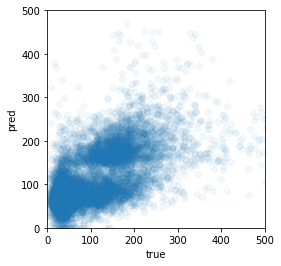

In [68]:
plt.scatter(y_dev, pred_dev, alpha = 0.05)
plt.axis('square')
plt.xlabel("true")
plt.ylabel("pred")


#plt.xlim(-10,10)
#plt.ylim(-10,10)

plt.xlim(0,500)
plt.ylim(0,500)

#plt.xlim(0,1)
#plt.ylim(0,1)

#plt.xlim(0,100)
#plt.ylim(0,100)

#plt.xlim(0,10)
#plt.ylim(1,10)


plt.show()

In [69]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [70]:
mean_squared_error(pred_dev, y_dev) #, squared=False) # hard to interpret

9276.382681746127

In [71]:
mean_absolute_error(pred_dev, y_dev)

56.87807704733264

In [72]:
explained_variance_score(y_dev, pred_dev) # what does this number mean? ... (1.0 is best)

0.3333691788475941

In [73]:
(st.pearsonr(pred_dev, y_dev)[0])**2

0.3334783754344506

## Beobachtung

Bei pageviews vielleicht eher den Titel oder Teaser als den Text selbst nehmen? (--> etwas besser, dann aber min_df ändern) --> Titel ist besser als Teaser (vielleicht auch sinnvoller?)

Welches Label ist das sinnvollste?

Welche Metrik? Pearson Korrelation? Mean Squared/Absolute Error?

Problem: Target-Varieblen sind sehr unausgeglichen, wenige Artikel mit sehr hoher pageview-Zahl (outliers)

## Trying SHAP

In [74]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [75]:
# hier auswählen, auf welchem Set Shap-Werte berechnet und visualisiert werden
explain_set = X_dev
explain_df = df_dev

In [76]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(explain_set)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


In [77]:
explain_set.shape

(9776, 500)

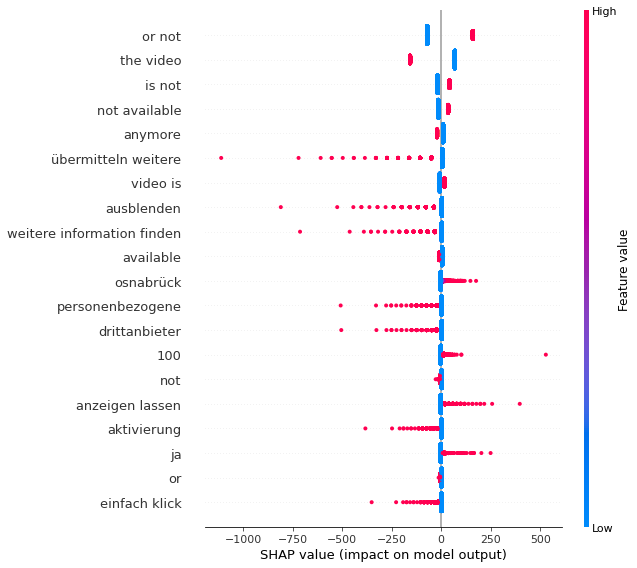

In [78]:
shap.summary_plot(shap_values, explain_set, feature_names=vectorizer.get_feature_names())

# rot/blau zeigt Feature Value, also rot=Feature ist da, blau=Feature ist nicht da

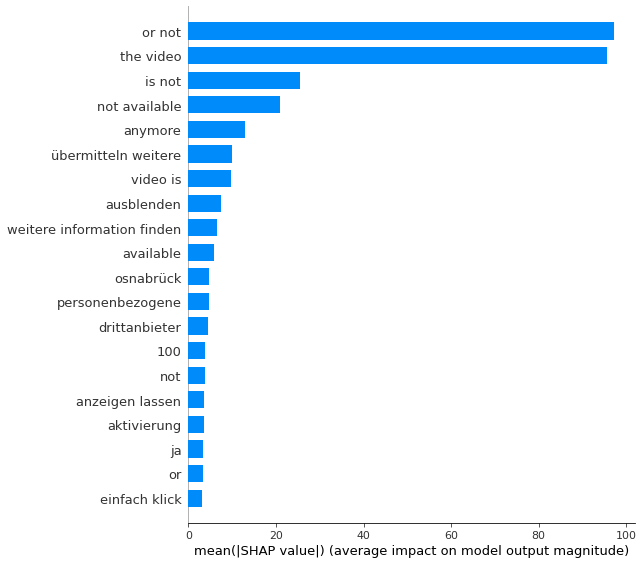

In [79]:
shap.summary_plot(shap_values, explain_set, plot_type="bar", feature_names=vectorizer.get_feature_names())

In [80]:
#shap.force_plot(explainer.expected_value, 
#                shap_values, 
#                explain_set, 
#                feature_names=vectorizer.get_feature_names())

# was zeigt das hier genau???

In [81]:
ind = 0
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                explain_set[ind,:],
                feature_names=vectorizer.get_feature_names()
               )

In [125]:
explain_df.iloc[ind].titel

'Zwei Tote nach schwerem Motorradunfall in der Vulkaneifel'

In [126]:
ind = 4
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                explain_set[ind,:],
                feature_names=vectorizer.get_feature_names()
               )

In [130]:
explain_df.iloc[ind].article_text[:300]

'G-Exit mit Folgen: Nach Geschwindes Austritt: Was sich in Bad Laers Politik alles ändert Von Frank Wiebrock The video is not or not available anymore Bad Laer . Der Bad Laerer Rat hat die Folgen des Austritts von Michael Geschwinde aus der CDU/Grünen-Gruppe auf- und abgearbeitet. Geschwinde ist dami'

In [131]:
ind = 11
shap.force_plot(explainer.expected_value,
                shap_values[ind,:],
                explain_set[ind,:],
                feature_names=vectorizer.get_feature_names()
               )

In [132]:
explain_df.iloc[ind].article_text[:300]

'Merzig Christian Marx heißt der neue Leiter des Verkehrsdienstes West. Mit 28 Kollegen ist er für den Grünen Kreis und Kreis Saarlouis zuständig. Für die Ernennung ihres Mannes Christian Marx zum Leiter des Verkehrsdienstes West lässt sich Elisabeth Marx nicht lumpen. Über Stunden stellte sich die s'

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


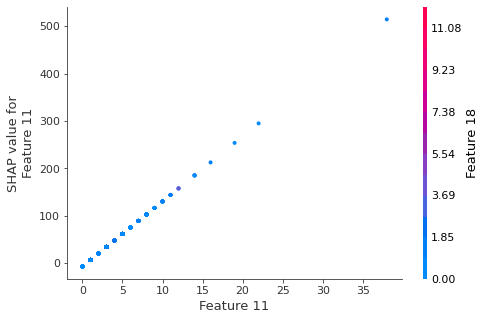

In [140]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(11, shap_values, explain_set)#, feature_names=vectorizer.get_feature_names())